In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

plt.style.use('seaborn')
sns.set(style = 'white')
%matplotlib inline

# Portfolio 1: Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [2]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
# strava.index = strava.index.tz_convert('UTC')
strava.head()

average_heartrate  average_temp  average_watts  \
date                                                                        
2018-01-02 20:47:51+00:00              100.6          21.0           73.8   
2018-01-04 01:36:53+00:00                NaN          24.0          131.7   
2018-01-04 02:56:00+00:00               83.1          25.0           13.8   
2018-01-04 05:37:04+00:00              110.1          24.0          113.6   
2018-01-05 19:22:46+00:00              110.9          20.0          147.7   

                          device_watts  distance  elapsed_time elevation_gain  \
date                                                                            
2018-01-02 20:47:51+00:00        False      15.2            94       316.00 m   
2018-01-04 01:36:53+00:00        False      18.0            52       236.00 m   
2018-01-04 02:56:00+00:00        False       0.0             3         0.00 m   
2018-01-04 05:37:04+00:00        False      22.9            77       246.00 m   
2018-01-05 19:22:46+00:00         True      58.4           189       676.00 m   

                           kudos  moving_time workout_type  
date                                                        
2018-01-02 20:47:51+00:00     10           73         Ride  
2018-01-04 01:36:53+00:00      5           46         Ride  
2018-01-04 02:56:00+00:00      2            2         Ride  
2018-01-04 05:37:04+00:00      8           64         Ride  
2018-01-05 19:22:46+00:00     12          144         Ride

The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [3]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

date      time                  filename  \
2018-01-28 06:39:49+11:00  01/28/18  06:39:49  2018_01_28_06_39_49.json   
2018-01-28 07:01:32+11:00  01/28/18  07:01:32  2018_01_28_07_01_32.json   
2018-02-01 08:13:34+11:00  02/01/18  08:13:34  2018_02_01_08_13_34.json   
2018-02-06 08:06:42+11:00  02/06/18  08:06:42  2018_02_06_08_06_42.json   
2018-02-07 17:59:05+11:00  02/07/18  17:59:05  2018_02_07_17_59_05.json   

                           axPower  aPower Relative Intensity  aBikeScore  \
2018-01-28 06:39:49+11:00  202.211                    0.75452     16.6520   
2018-01-28 07:01:32+11:00  226.039                    0.84343     80.2669   
2018-02-01 08:13:34+11:00    0.000                    0.00000      0.0000   
2018-02-06 08:06:42+11:00  221.672                    0.82714     78.8866   
2018-02-07 17:59:05+11:00  218.211                    0.81422    159.4590   

                           Skiba aVI  aPower Response Index  aIsoPower  \
2018-01-28 06:39:49+11:00    1.31920                1.67755    223.621   
2018-01-28 07:01:32+11:00    1.21137                1.54250    246.185   
2018-02-01 08:13:34+11:00    0.00000                0.00000      0.000   
2018-02-06 08:06:42+11:00    1.35775                1.86002    254.409   
2018-02-07 17:59:05+11:00    1.47188                1.74658    233.780   

                               aIF  ...  Rest AVNN  Rest SDNN  Rest rMSSD  \
2018-01-28 06:39:49+11:00  0.83441  ...          0          0           0   
2018-01-28 07:01:32+11:00  0.91860  ...          0          0           0   
2018-02-01 08:13:34+11:00  0.00000  ...          0          0           0   
2018-02-06 08:06:42+11:00  0.94929  ...          0          0           0   
2018-02-07 17:59:05+11:00  0.87231  ...          0          0           0   

                           Rest PNN50  Rest LF  Rest HF  HRV Recovery Points  \
2018-01-28 06:39:49+11:00           0        0        0                    0   
2018-01-28 07:01:32+11:00           0        0        0                    0   
2018-02-01 08:13:34+11:00           0        0        0                    0   
2018-02-06 08:06:42+11:00           0        0        0                    0   
2018-02-07 17:59:05+11:00           0        0        0                    0   

                                NP       IF       TSS  
2018-01-28 06:39:49+11:00  222.856  0.83155   20.2257  
2018-01-28 07:01:32+11:00  245.365  0.91554   94.5787  
2018-02-01 08:13:34+11:00    0.000  0.00000    0.0000  
2018-02-06 08:06:42+11:00  253.702  0.94665   98.3269  
2018-02-07 17:59:05+11:00  232.644  0.86808  171.0780  

[5 rows x 362 columns]

The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in their documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

## Merging Strava and Cheetah Datasets
We merge the **strava** data with the **cheetah** data using their indices to match observations from one dataset to the other. We specify an inner join to capture the observations that are common in both datasets.

In [4]:
cycling = strava.join(cheetah, how = "inner")
print('The dimensions of the Cycling Data is: {}'.format(cycling.shape))

The dimensions of the Cycling Data is: (243, 372)


The resulting dataset, which we named the **cycling** data, has 243 observations (rows) and 372 variables (columns).

## Cycling Dataset Exploratory Analysis
We remove the cycling rides that have no recorded power reading as these are considered as commutes and MTB rides.

In [5]:
cycling_complete = cycling[cycling["device_watts"] == True]
print('The dimensions of Cycling Data after removing commutes and MTB rides is: {}'.format(cycling_complete.shape))

The dimensions of Cycling Data after removing commutes and MTB rides is: (205, 372)


There are 38 rides with such condition and when omitted from our **cycling** dataset, we are left with 209 observations. We named this the **cycling_complete** dataset.

### Converting Variables as Factors and Creating New Variables
The *workout_type* variable is currently coded as character and we proceed with converting it into categorical data to be used in our succeeding analysis. The elevation gain data is encoded with it's unit of measurement (meters). We extract the numeric part of *elevation_gain* and drop the unit of measurement.

In [6]:
cycling_complete['workout_type'] = cycling_complete.workout_type.astype('category')
cycling_complete['elevation_gain'] = cycling_complete.elevation_gain.str.replace('[^\d\.\d]', '').astype('float')

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/jvlpz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Since our dataset contains 372 variables and we are interested on only a handful of them, we define an object that contains our variables of interest. Let's display the first 5 observations of the data frame with the relevant variables only.

In [7]:
factors = ["distance", "moving_time", "Average Speed", "average_heartrate", "average_watts", "NP", "TSS", "elevation_gain", "workout_type"]
cycling_complete[factors].head()

distance  moving_time  Average Speed  \
2018-01-27 19:39:49+00:00       7.6           17        26.0234   
2018-01-27 20:01:32+00:00      38.6           67        34.4380   
2018-02-05 21:06:42+00:00      24.3           65        22.2417   
2018-02-07 06:59:05+00:00      47.1          134        20.7841   
2018-02-09 19:18:03+00:00      59.8          139        25.6585   

                           average_heartrate  average_watts       NP  \
2018-01-27 19:39:49+00:00              120.6          153.4  222.856   
2018-01-27 20:01:32+00:00              146.9          187.7  245.365   
2018-02-05 21:06:42+00:00              119.3          165.9  253.702   
2018-02-07 06:59:05+00:00              124.8          151.0  232.644   
2018-02-09 19:18:03+00:00              123.0          145.9  212.726   

                                TSS  elevation_gain workout_type  
2018-01-27 19:39:49+00:00   20.2257            95.0         Ride  
2018-01-27 20:01:32+00:00   94.5787           449.0         Race  
2018-02-05 21:06:42+00:00   98.3269           439.0         Ride  
2018-02-07 06:59:05+00:00  171.0780           890.0         Ride  
2018-02-09 19:18:03+00:00  147.7970           656.0         Ride

### Summary Statistics

In [8]:
cycling_complete[factors].describe()

distance  moving_time  Average Speed  average_heartrate  \
count  205.000000   205.000000     205.000000         185.000000   
mean    35.519512    83.170732      25.707538         123.667568   
std     21.290148    51.330868       4.734588          13.024952   
min      0.000000    10.000000       4.737600          73.300000   
25%     19.800000    46.000000      23.079100         116.900000   
50%     32.100000    64.000000      25.107200         122.300000   
75%     58.100000   135.000000      26.711200         129.900000   
max    108.200000   236.000000      38.350200         156.500000   

       average_watts          NP         TSS  elevation_gain  
count     205.000000  205.000000  205.000000      205.000000  
mean      167.632195  223.127137  100.537880      359.576585  
std        32.632763   30.130636   69.170757      320.012227  
min       103.700000  139.591000    7.239700        0.000000  
25%       143.000000  205.448000   44.127400       52.000000  
50%       163.700000  223.192000   82.356800      312.000000  
75%       189.600000  241.060000  159.363000      595.000000  
max       266.600000  302.396000  412.071000     1474.000000

The average distance travelled when cycling is 35.52 kilometers, with half of the rides covering more than 32.10 kilometers and the farthest cycling distance being 108.20 kilometers. On average, the cycling speed is 25.71 km/hr and 50% of the rides have over 25.11 km/hr cycling speed with the fastest being 38.35 km/hr. The average heart rate per ride is 123.67 bpm with the highest being 156.5 bpm. Note that there are 20 rides in our dataset that does not have an average heart rate reading. The average power per ride is 167.63 watts, average normalised power is 223.12 watts and the average training stress score is 100.54. The highest elevation climbed on a ride is 1,474 meters and the average elevation climbed per ride is 359.58 meters.

### Visualising the Distributions of Key Variables
We now look at the distribution of key variables in our dataset: distance, moving time, average speed, average power and training stress score. The observations on the distribution of the variables are discussed after the last histogram plot.

Skewness of the distribution of distance:  0.5132584678230234


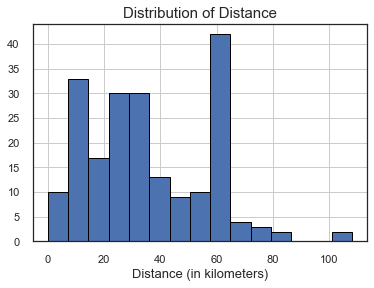

In [9]:
plt_dist = cycling_complete.distance.hist(density = 0, bins = 15, edgecolor = 'black')
plt_dist.set_title('Distribution of Distance', size = 15)
plt_dist.set_xlabel('Distance (in kilometers)', size = 13)
print("Skewness of the distribution of distance: ", cycling_complete.distance.skew())

Skewness of the distribution of time:  0.5636319808541944


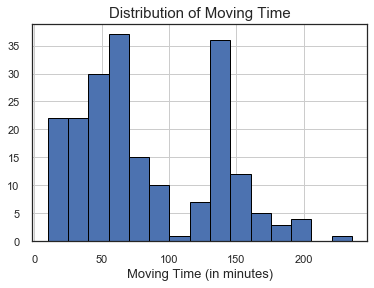

In [10]:
plt_time = cycling_complete.moving_time.hist(density = 0, bins = 15, edgecolor = 'black')
plt_time.set_title('Distribution of Moving Time', size = 15)
plt_time.set_xlabel('Moving Time (in minutes)', size = 13)
print("Skewness of the distribution of time: ", cycling_complete.moving_time.skew())

Skewness of the distribution of average speed:  0.43621318841282203


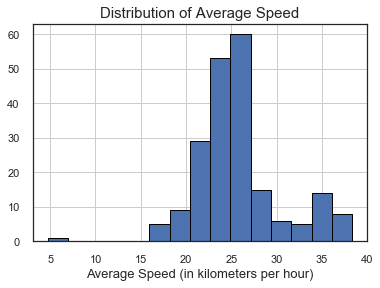

In [11]:
plt_speed = cycling_complete['Average Speed'].hist(density = 0, bins = 15, edgecolor = 'black')
plt_speed.set_title('Distribution of Average Speed', size = 15)
plt_speed.set_xlabel('Average Speed (in kilometers per hour)', size = 13)
print("Skewness of the distribution of average speed: ", cycling_complete['Average Speed'].skew())

Skewness of the distribution of average power:  0.5401996157445961


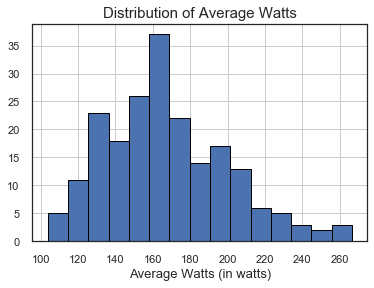

In [12]:
plt_watts = cycling_complete.average_watts.hist(density = 0, bins = 15, edgecolor = 'black')
plt_watts.set_title('Distribution of Average Watts', size = 15)
plt_watts.set_xlabel('Average Watts (in watts)', size = 13)
print("Skewness of the distribution of average power: ", cycling_complete.average_watts.skew())

Skewness of the distribution of training stress score:  1.0832346587856845


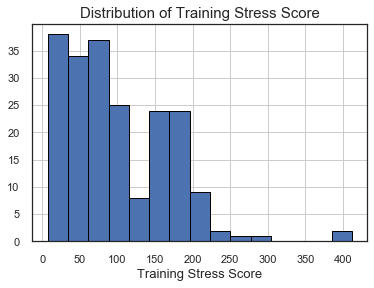

In [13]:
plt_tss = cycling_complete.TSS.hist(density = 0, bins = 15, edgecolor = 'black')
plt_tss.set_title('Distribution of Training Stress Score', size = 15)
plt_tss.set_xlabel('Training Stress Score', size = 13)
print("Skewness of the distribution of training stress score: ", cycling_complete.TSS.skew())

By looking at the histograms, the variables don't seem to follow the normal distribution. We also compute for the skewness of each distribution and conclude that all of them are positively skewed.

### Correlations Between the Variables of Interest
Let's define a function that displays the Pearson's correlation coefficient for each variable pair in our dataset.

In [14]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha = 0.6, cmap = "coolwarm",
               vmin = -1, vmax = 1, transform = ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords = "axes fraction",
                ha = 'center', va = 'center', fontsize = font_size)

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jvlpz/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


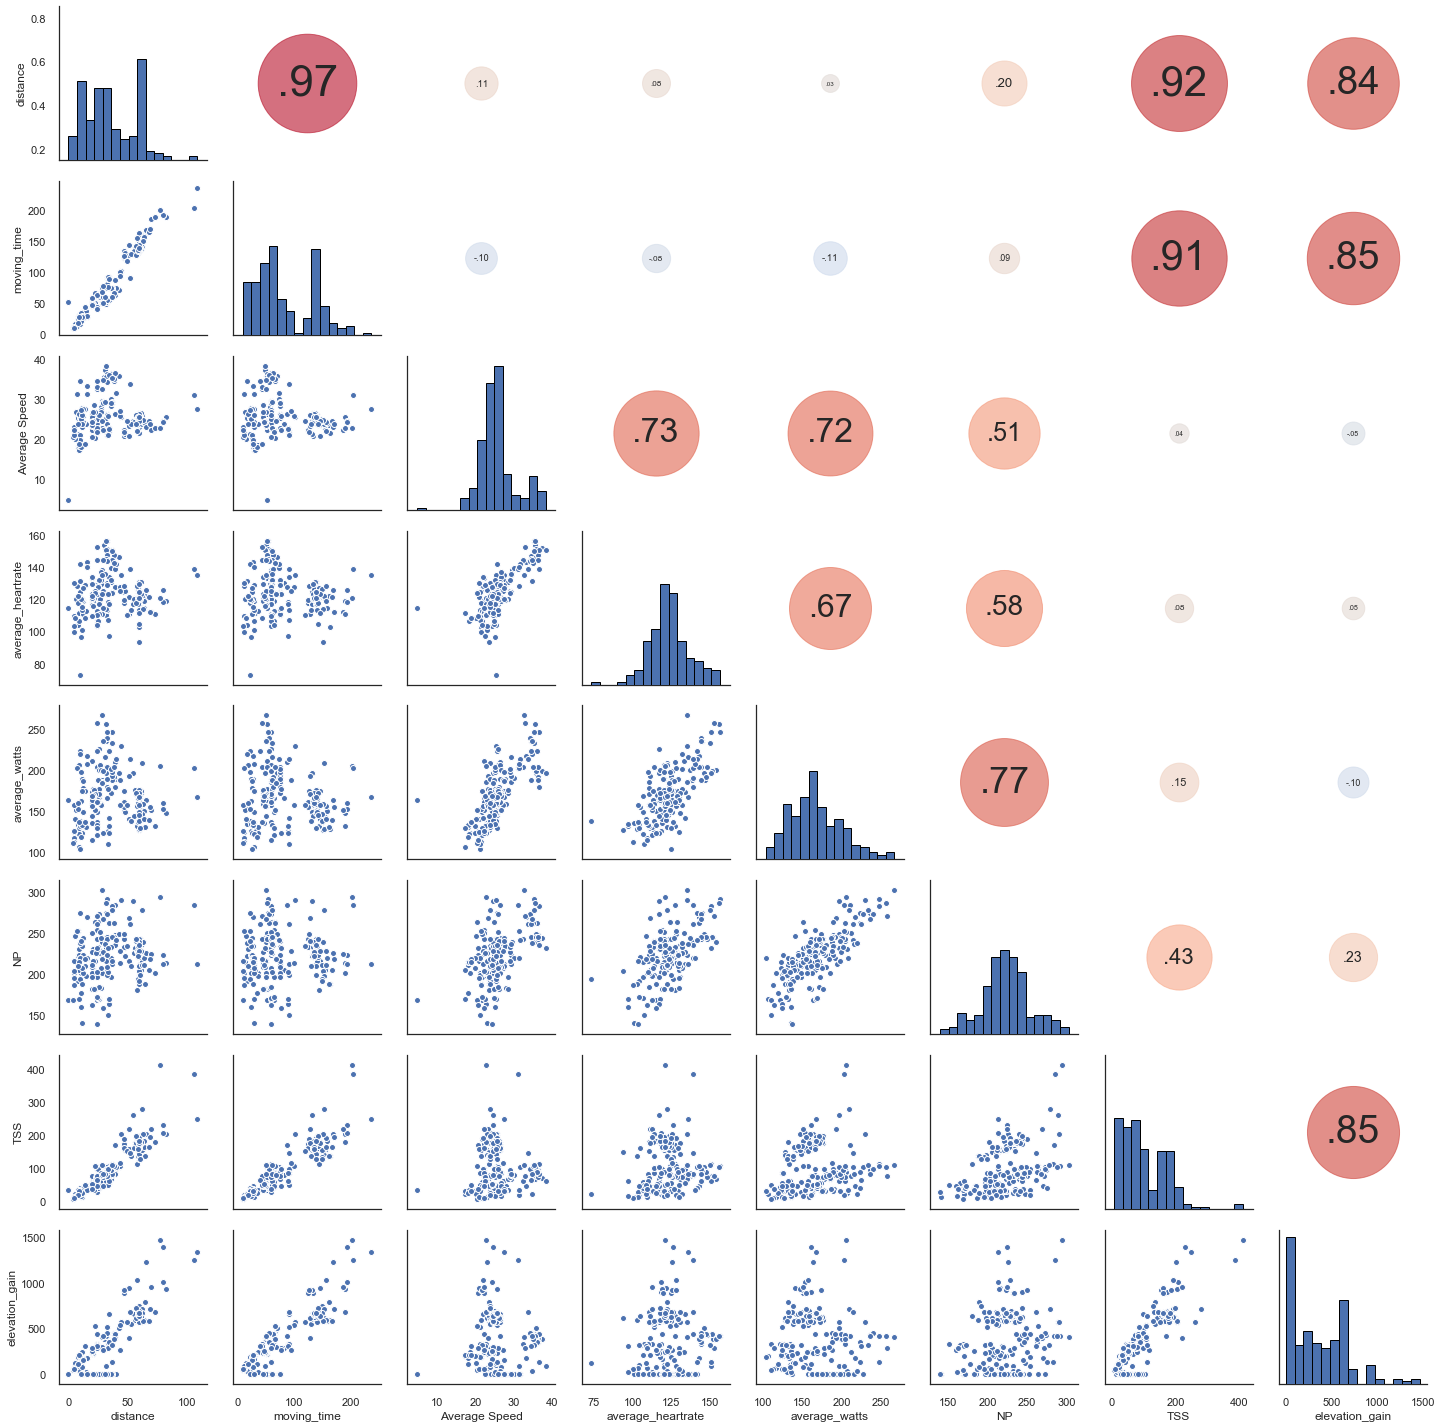

In [15]:
corr_plot = sns.PairGrid(cycling_complete[factors])
corr_plot.map_diag(plt.hist, bins = 15, edgecolor = "black")
corr_plot.map_lower(plt.scatter, edgecolor = "white")
corr_plot.map_upper(corrdot)

Significant relationships can be observed among our variables of interest. The size of the circle represents the strength of the relationship between the variables, the figure inside is the Pearson correlation coefficient, with values ranging from -1 (perfectly negative correlation) to 1 (perfectly positive correlation), and the stronger the shade of red, the more significant the relationship is:
* All significant relationships are positively correlated.
* Distance and moving time are very highly correlated, as should be expected since it takes more time to cover longer distances.
* A very strong correlation can also be observed between distance and training stress score. This might be due to rides becoming tougher and more difficult the longer the distance cycled. Similar relationship can be observed with moving time and training stress score.
* Training stress score and elevation gain are highly correlated as it takes more effort and energy to climb higher elevations.
* Elevation gain are highly positively associated with distance and moving time. These associations might be due to the following: (1) climbing higher elevations take longer time since cycling uphill takes a lot effort, and (2) climbing steeper slopes to get to a certain elevation might require detours which cover a longer distance.
* High positive correlation is observed between average speed, average heart rate, average power and normalised power. Faster cycling speed require more effort which can increase the heart rate.

### Exploring the Workout Types

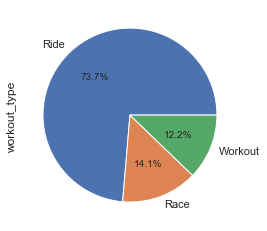

In [16]:
cycling_complete.workout_type.value_counts().plot.pie(autopct='%1.1f%%')

The cycling dataset is composed of 73.7% rides, and 14.1% races and 12.2% workouts. We'll look at a subset of variables and highlight the differences between each workout type.

We'll define a function that will serve as a template for our boxplot to compare each workout type.

In [17]:
def mod_boxplot(x, y, ax0, ax1, xlabel):
    ax = sns.boxplot(x = x, y = y, data = cycling_complete, ax = axs[ax0, ax1])
    ax.set_xlabel(xlabel, size = 25)
    ax.set_xticklabels(ax.get_xmajorticklabels(), size = 25)
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_ymajorticklabels(), size = 25)
    return ax

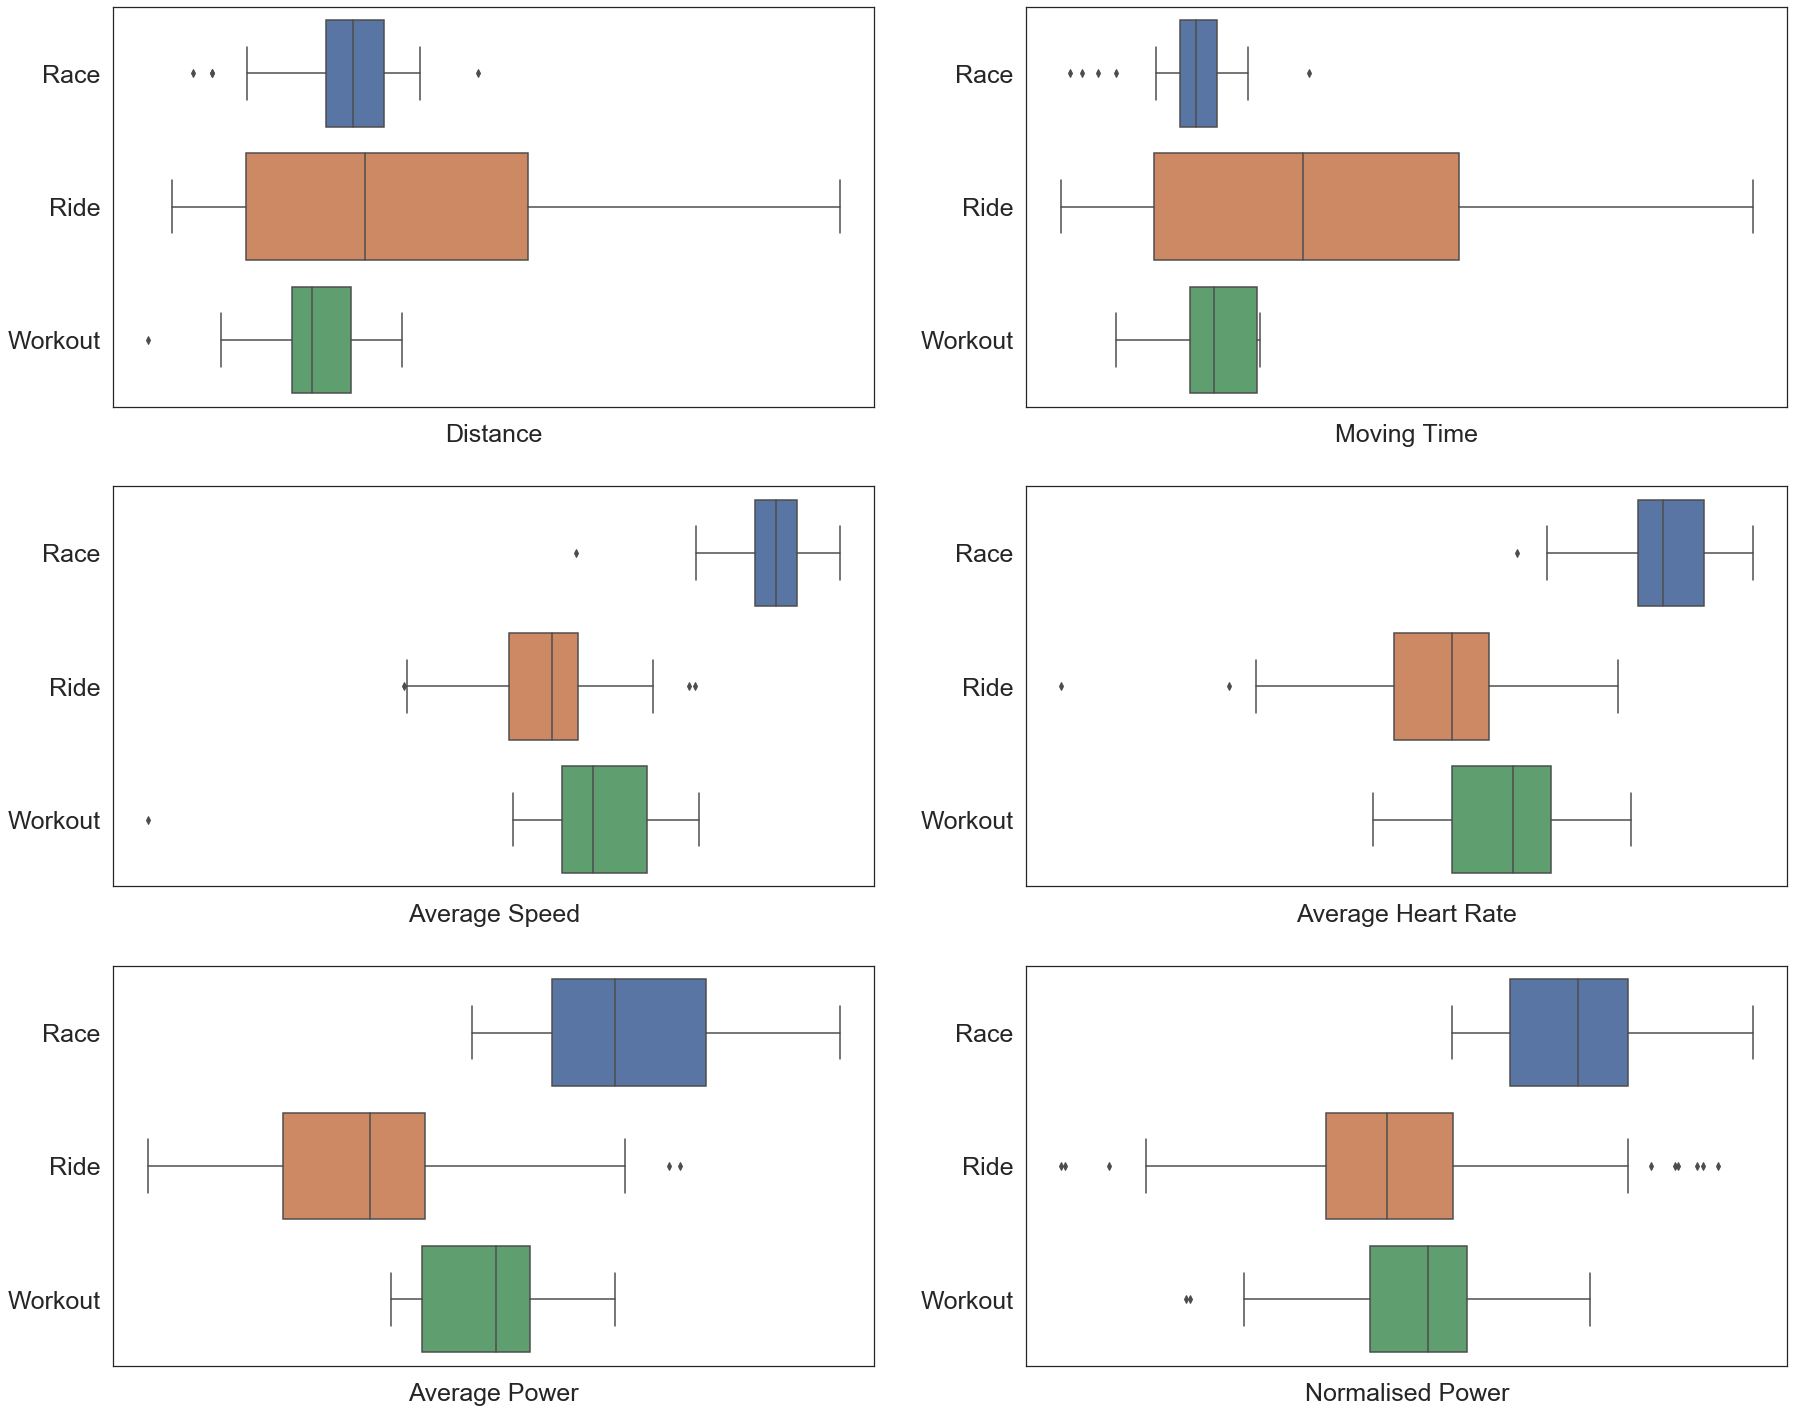

In [18]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize=(30,25))

mod_boxplot('distance', 'workout_type', 0, 0, 'Distance')
mod_boxplot('moving_time', 'workout_type', 0, 1, 'Moving Time')
mod_boxplot('Average Speed', 'workout_type', 1, 0, 'Average Speed')
mod_boxplot('average_heartrate', 'workout_type', 1, 1, 'Average Heart Rate')
mod_boxplot('average_watts', 'workout_type', 2, 0, 'Average Power')
mod_boxplot('NP', 'workout_type', 2, 1, 'Normalised Power')

The median distance covered during rides and races are not that different but the spread/range of values is wider for rides due to more datapoints. The median distance covered for workouts are less than both distance covered on race and rides.

Races are finished in a shorter time as compared to rides even if they have identical median distance covered. Workouts are finished in a shorter time compared to rides. Again, the spread/range of values for rides is wider compared to the other two types of workout and it is due to more datapoints available for rides.

The average speed, average heart rate, average power and normalised power are higher for races as compared to rides and workouts. Rides have the lowest average speed, average heart rate, average power and normalised power among the three workout types.

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/jvlpz/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


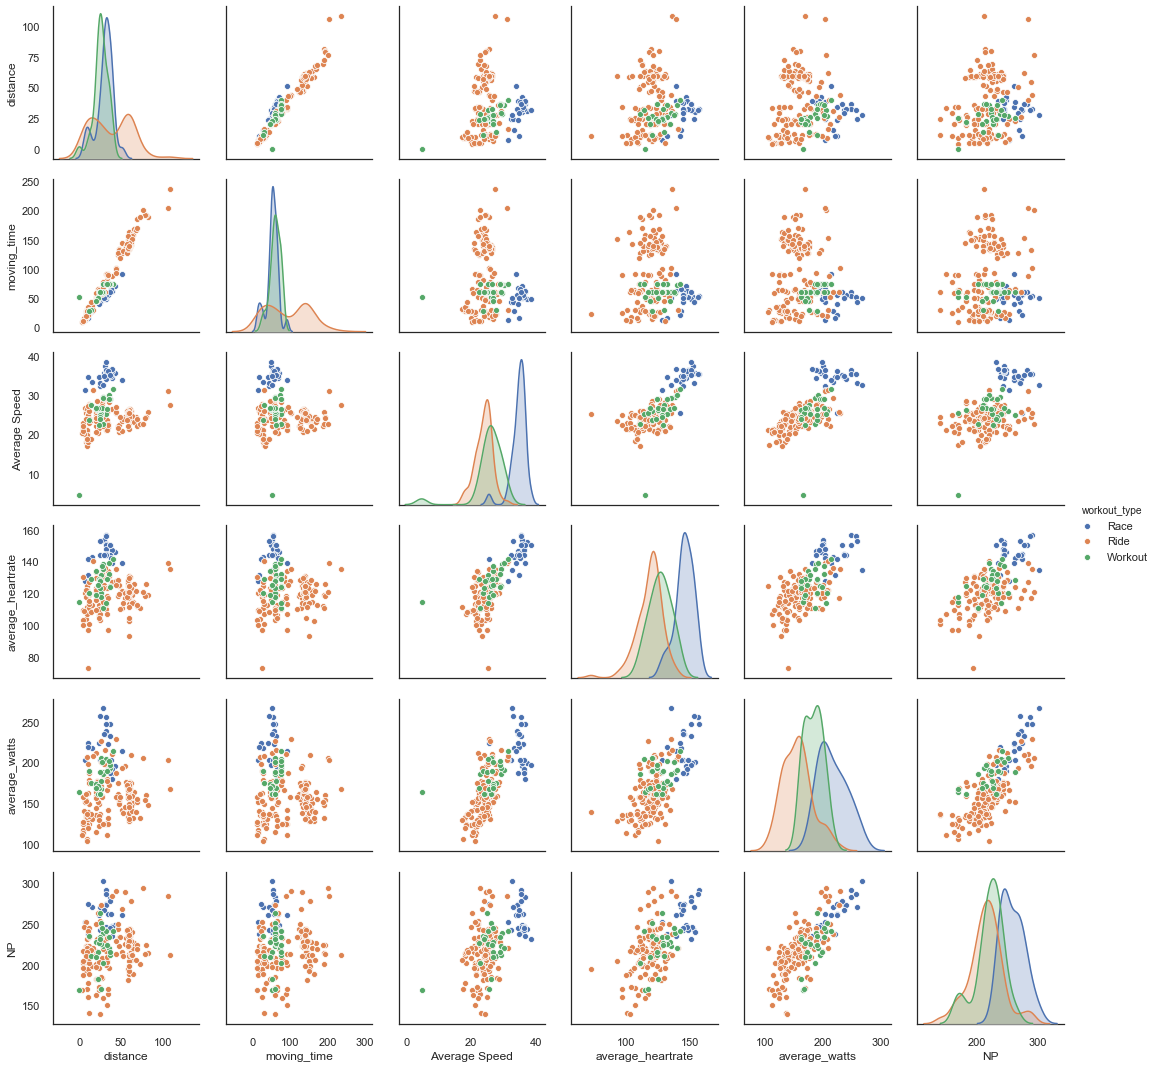

In [19]:
corr_plot_workout = sns.pairplot(cycling_complete[['distance', 'moving_time', 'Average Speed', 'average_heartrate', 'average_watts', 'NP', 'workout_type']], hue = "workout_type")

The scatterplot matrix confirms the observations made above.

## Summary Statistics and Distribution of Kudos

In [20]:
cycling_complete.kudos.describe()

count    205.000000
mean      11.531707
std        5.508035
min        2.000000
25%        7.000000
50%       11.000000
75%       16.000000
max       24.000000
Name: kudos, dtype: float64

On average, a ride receives 11.53 kudos. The highest number of kudos that a ride got is 24 and the lowest is 2.

Skewness of the distribution of kudos:  0.22282575097149607


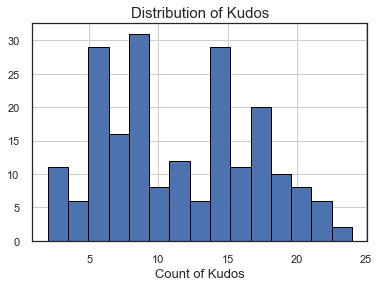

In [21]:
plt_kudos = cycling_complete.kudos.hist(density = 0, bins = 15, edgecolor = 'black')
plt_kudos.set_title('Distribution of Kudos', size = 15)
plt_kudos.set_xlabel('Count of Kudos', size = 13)
print("Skewness of the distribution of kudos: ", cycling_complete.kudos.skew())

The kudos distribution does not follow a normal distribution, its skewness is 0.22 which means the distribution is moderately symmetic.

## What Gets More Kudos?

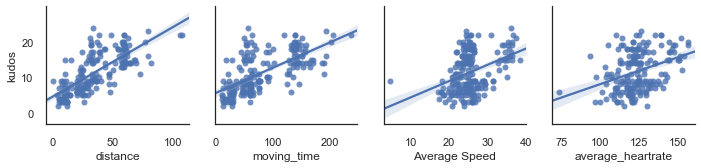

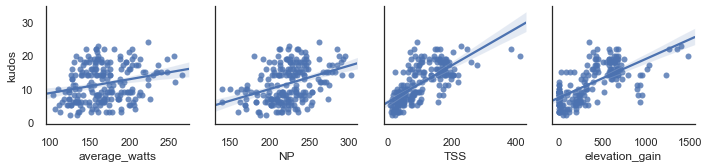

In [22]:
sns.pairplot(data = cycling_complete, y_vars = ['kudos'], x_vars = factors[0:4], kind = 'reg')
sns.pairplot(data = cycling_complete, y_vars = ['kudos'], x_vars = factors[4:8], kind = 'reg')

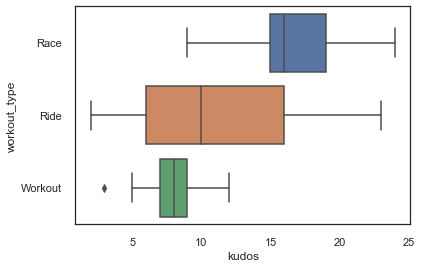

In [23]:
sns.boxplot(x = 'kudos', y = 'workout_type', data = cycling_complete)

Generally, kudos is positively correlated with the key variables as displayed in the scatterplots above. Races get higher kudos as compared to rides and workouts. Workouts have the lowest median kudos out of the three workout types.

## Plot of Distance, Stress and Speed per Month

We first get a subset of the cycling data containing all the variables of interest. We compute for the start of the month to be used as the index of our plot, extract the month-year information from it and convert them into string data. Then, we perform aggregation on the month-year variable and calculate the total distance, total stress and average of average speed. We then create plots for the aggregated data and label the plot as necessary.

In [24]:
plot_cycling = cycling_complete[['distance', 'TSS', 'Average Speed']]
plot_cycling['month'] = (plot_cycling.index - pd.offsets.MonthBegin(1)).date
plot_cycling.head()

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


distance       TSS  Average Speed       month
2018-01-27 19:39:49+00:00       7.6   20.2257        26.0234  2018-01-01
2018-01-27 20:01:32+00:00      38.6   94.5787        34.4380  2018-01-01
2018-02-05 21:06:42+00:00      24.3   98.3269        22.2417  2018-02-01
2018-02-07 06:59:05+00:00      47.1  171.0780        20.7841  2018-02-01
2018-02-09 19:18:03+00:00      59.8  147.7970        25.6585  2018-02-01

In [25]:
table1 = plot_cycling.groupby('month').sum()[['distance', 'TSS']]
table2 = plot_cycling.groupby('month').mean()['Average Speed']
monthly_plot = table1.join(table2, how = "inner")
monthly_plot = monthly_plot.reset_index()
monthly_plot.columns = ['month', 'total_distance', 'total_stress', 'average_speed']
monthly_plot = monthly_plot.sort_values('month')
monthly_plot['month_year'] = monthly_plot.month.apply(lambda x: x.strftime('%B %Y'))
monthly_plot.head()

month  total_distance  total_stress  average_speed     month_year
0  2018-01-01            46.2      114.8044      30.230700   January 2018
1  2018-02-01           423.4     1282.4769      23.429608  February 2018
2  2018-03-01           487.3     1390.8382      26.157382     March 2018
3  2018-04-01           368.4     1119.6003      22.733291     April 2018
4  2018-05-01           333.0      889.4034      24.564975       May 2018

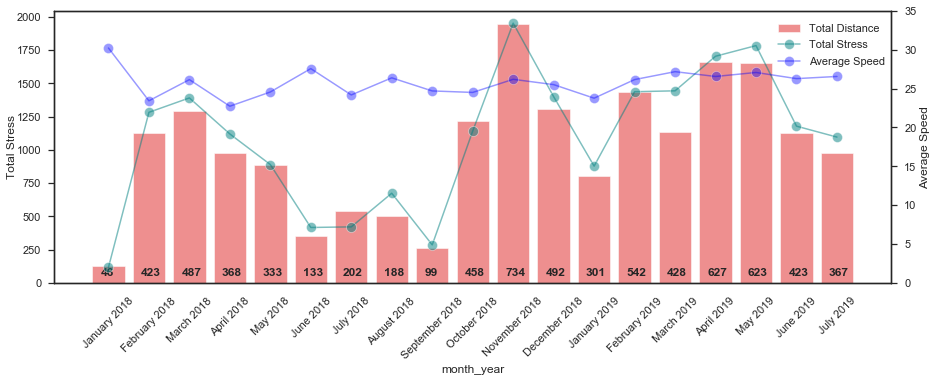

In [26]:
fig, ax = plt.subplots(figsize = (15, 5))
distance_plot = sns.barplot('month_year', 'total_distance', data = monthly_plot, color = 'red',
                            ax = ax, alpha = 0.5, label = 'Total Distance')
distance_plot.set(yticks = [], ylabel = 'Total Stress')
distance_plot.set_xticklabels(distance_plot.get_xticklabels(), rotation = 45)
distance_plot.yaxis.labelpad = 37

for i, v in enumerate(monthly_plot.total_distance):
    distance_plot.text(i - 0.2,
                       v / monthly_plot.total_distance[i] + 20,
                       '%i' % monthly_plot.total_distance[i],
                       fontsize = 12,
                       fontweight = 'bold')

ax2 = ax.twinx()
stress_plot = sns.lineplot('month_year', 'total_stress', data = monthly_plot, color = 'teal',
                           ax = ax2, marker = 'o', markersize = 10, alpha = 0.5, label = 'Total Stress', sort = False)
stress_plot.set(ylabel = '', ylim = (0, None))

ax3 = ax2.twinx()
speed_plot = sns.lineplot('month_year', 'average_speed', data = monthly_plot, color = 'blue', ax = ax3,
                          marker = 'o', markersize = 10, alpha = 0.4, label = 'Average Speed', sort = False)
speed_plot.set(ylabel = 'Average Speed', ylim = (0, 35))

ax.legend(loc = (.86, .9), frameon = False)
ax2.legend( loc = (.86, .84), frameon = False)
ax3.legend( loc = (.86, .78), frameon = False)

Total distance and stress seem to move similarly with each other month to month. The average speed, on the other hand, don't seem to be proportional with either distance and stress.

## Plot of Distance, Stress and Speed per Date of a Given Month

A similar approach is done for the plot by date. This time, we create a function that takes in a month as a parameter and displays the plot for that month in the two years that span our dataset.

In [27]:
plot_cycling['date'] = plot_cycling.index.date
plot_cycling.head()

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


distance       TSS  Average Speed       month  \
2018-01-27 19:39:49+00:00       7.6   20.2257        26.0234  2018-01-01   
2018-01-27 20:01:32+00:00      38.6   94.5787        34.4380  2018-01-01   
2018-02-05 21:06:42+00:00      24.3   98.3269        22.2417  2018-02-01   
2018-02-07 06:59:05+00:00      47.1  171.0780        20.7841  2018-02-01   
2018-02-09 19:18:03+00:00      59.8  147.7970        25.6585  2018-02-01   

                                 date  
2018-01-27 19:39:49+00:00  2018-01-27  
2018-01-27 20:01:32+00:00  2018-01-27  
2018-02-05 21:06:42+00:00  2018-02-05  
2018-02-07 06:59:05+00:00  2018-02-07  
2018-02-09 19:18:03+00:00  2018-02-09

In [28]:
table1 = plot_cycling.groupby('date').sum()[['distance', 'TSS']]
table2 = plot_cycling.groupby('date').mean()['Average Speed']
daily_plot = table1.join(table2, how = "inner")
daily_plot = daily_plot.reset_index()
daily_plot['month'] = daily_plot.date.apply(lambda x: x.strftime('%B'))
daily_plot.columns = ['date', 'total_distance', 'total_stress', 'average_speed', 'month']
daily_plot.date = daily_plot.date.apply(lambda x: x.strftime('%Y-%m-%d'))
daily_plot.head()

date  total_distance  total_stress  average_speed     month
0  2018-01-27            46.2      114.8044        30.2307   January
1  2018-02-05            24.3       98.3269        22.2417  February
2  2018-02-07            47.1      171.0780        20.7841  February
3  2018-02-09            59.8      147.7970        25.6585  February
4  2018-02-10            38.8       85.0492        31.3581  February

In [29]:
def monthly_cycling(m):
    month_subset = daily_plot[daily_plot.month == m].reset_index()

    fig, ax = plt.subplots(figsize = (15, 5))
    distance_d_plot = sns.barplot('date', 'total_distance', data = month_subset, color = 'red',
                                ax = ax, alpha = 0.5, label = 'Total Distance')
    distance_d_plot.set(yticks = [], ylabel = 'Total Stress')
    distance_d_plot.set_xticklabels(distance_d_plot.get_xticklabels(), rotation = 45)
    distance_d_plot.yaxis.labelpad = 32
    
    for i, v in enumerate(month_subset.total_distance):
        distance_d_plot.text(i,
                             v / month_subset.total_distance[i],
                             '%i' % month_subset.total_distance[i],
                             fontsize = 12,
                             fontweight = 'bold')

    ax2 = ax.twinx()
    stress_d_plot = sns.lineplot('date', 'total_stress', data = month_subset, color = 'teal',
                                 ax = ax2, marker = 'o', markersize = 10, alpha = 0.5, label = 'Total Stress')
    stress_d_plot.set(ylabel = '', ylim = (0, None))

    ax3 = ax2.twinx()
    speed_d_plot = sns.lineplot('date', 'average_speed', data = month_subset, color = 'blue', ax = ax3,
                              marker = 'o', markersize = 10, alpha = 0.5, label = 'Average Speed')
    speed_d_plot.set(ylabel = 'Average Speed', ylim = (0, None))

    ax.legend(loc = (1.03, .9), frameon = False)
    ax2.legend( loc = (1.03, .84), frameon = False)
    ax3.legend( loc = (1.03, .78), frameon = False)
    
    return ax, ax2, ax3

(<matplotlib.axes._subplots.AxesSubplot at 0x1a2ac736d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23caac18>)

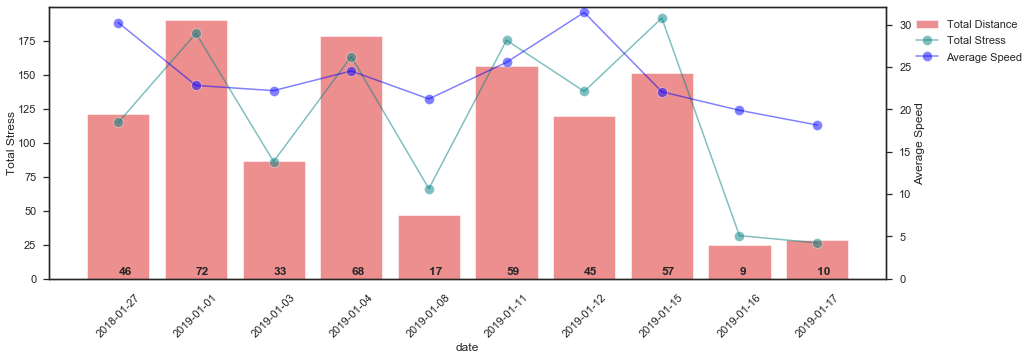

In [30]:
monthly_cycling('January')

(<matplotlib.axes._subplots.AxesSubplot at 0x1a23d6d9b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a27823860>)

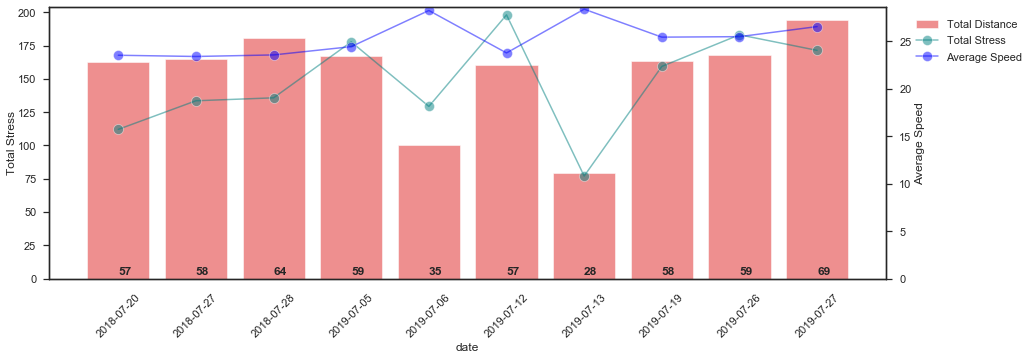

In [31]:
monthly_cycling('July')

# Portfolio 2: Data driven prediction models of energy use of appliances in a low-energy house
This notebook is a partial replication of the analysis exploring appliance energy consumption based on the research by Luis M. Candanedo, Véronique Feldheim and Dominique Deramaix. The research paper discusses how various variables, such as temperature, humidity and other weather parameters, can predict appliance energy consumption using different machine learning methods. Linear regression, support vector machines, random forests and gradient boosting machines were used for prediction and recursive feature elimination (RFE) was used to rank the predictor variable importance. This notebook will focus on the replication of the multiple linear regression method with RFE to select relevant features.


## Loading the Data
The dataset is collected from a house in Stambruges designed to have low energy consumption. The energy (Wh) data is recorded every 10 minutes to capture quick changes in energy consumption in the house. Lights energy consumption is also collected using a sub-metered load. Temperature and humidity reading are also taken from each room in the house. All these information were taken for 137 days and combined to form the energy dataset. We proceed with conducting exploratory analysis on this data. 

In [32]:
energy = pd.read_csv('data/energydata_complete.csv')
energy.date = pd.to_datetime(energy.date)
print('Dimensions of the energy dataset: ', energy.shape)
energy.head()

Dimensions of the energy dataset:  (19735, 29)


date  Appliances  lights     T1       RH_1    T2       RH_2  \
0 2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1 2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2 2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3 2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4 2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

The dataset contains 19,735 observations and 29 variables (2 of which are random variables and will be removed from our dataset later on). The description of the data can be found below.

## Data Description
Data variables and their description are listed below. We remove variables `rv1` and `rv2` as these are random variables that were not used in the prediction.
* __date__ - date and time when the observation was taken
* __Appliances__ - Appliances energy consumption
* __lights__ - Light energy consumption
* __T1__ - Temperature in kitchen area
* __RH_1__ - Humidity in kitchen area
* __T2__ - Temperature in living room area
* __RH_2__ - Humidity in living room area
* __T3__ - Temperature in laundry room area
* __RH_3__ - Humidity in laundry room area
* __T4__ Temperature in office room
* __RH_4__ - Humidity in office room
* __T5__ - Temperature in bathroom
* __RH_5__ - Humidity in bathroom
* __T6__ - Temperature outside the building (north side)
* __RH_6__ - Humidity outside the building (north side)
* __T7__ - Temperature in ironing room
* __RH_7__ - Humidity in ironing room
* __T8__ - Temperature in teenager room 2
* __RH_8__ - Humidity in teenager room 2
* __T9__ - Temperature in parents room
* __RH_9__ - Humidity in parents room
* __T_out__ - Temperature outside (from Chièvres weather station)
* __Press_mm_hg__ - Pressure (from Chièvres weather station)
* __RH_out__ - Humidity outside (from Chièvres weather station)
* __Windspeed__ - Windspeed (from Chièvres weather station)
* __Visibility__ - Visibility (from Chièvres weather station)
* __Tdewpoint__ - Tdewpoint (from Chièvres weather station)

In [33]:
energy = energy.drop(['rv1', 'rv2'], axis = 1)
energy.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0 2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1 2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2 2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3 2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4 2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...    T8       RH_8         T9   RH_9  \
0  19.79  44.730000  19.000000  ...  18.2  48.900000  17.033333  45.53   
1  19.79  44.790000  19.000000  ...  18.2  48.863333  17.066667  45.56   
2  19.79  44.933333  18.926667  ...  18.2  48.730000  17.000000  45.50   
3  19.79  45.000000  18.890000  ...  18.1  48.590000  17.000000  45.40   
4  19.79  45.000000  18.890000  ...  18.1  48.590000  17.000000  45.40   

      T_out  Press_mm_hg  RH_out  Windspeed  Visibility  Tdewpoint  
0  6.600000        733.5    92.0   7.000000   63.000000        5.3  
1  6.483333        733.6    92.0   6.666667   59.166667        5.2  
2  6.366667        733.7    92.0   6.333333   55.333333        5.1  
3  6.250000        733.8    92.0   6.000000   51.500000        5.0  
4  6.133333        733.9    92.0   5.666667   47.666667        4.9  

[5 rows x 27 columns]

In [34]:
print('Dimensions of complete energy dataset: ', energy.shape)

Dimensions of complete energy dataset:  (19735, 27)


We create extra features (number of seconds from midnight, week status and day of the week) to be included when fitting multiple linear regression model. Week status and day of the week are transformed as categorical variables and we impose ordering on the day of the week variable setting Sunday as the start of the week:
* NSM - number of seconds from midnight
* week_status - weekday or weekend
* day - day of the week

In [35]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
energy['NSM'] = energy.date.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
energy['week_status'] = energy.date.apply(lambda x: 'weekend' if (x.weekday() == 5 | x.weekday() == 6) else 'weekday').astype('category')
energy['day'] = energy.date.dt.day_name().astype('category')

## A Look at Energy Appliance Usage
We look at the overall trend of energy consumption of appliances for the entire period in the dataset.

Text(0.5, 1.0, 'Energy Consumption')

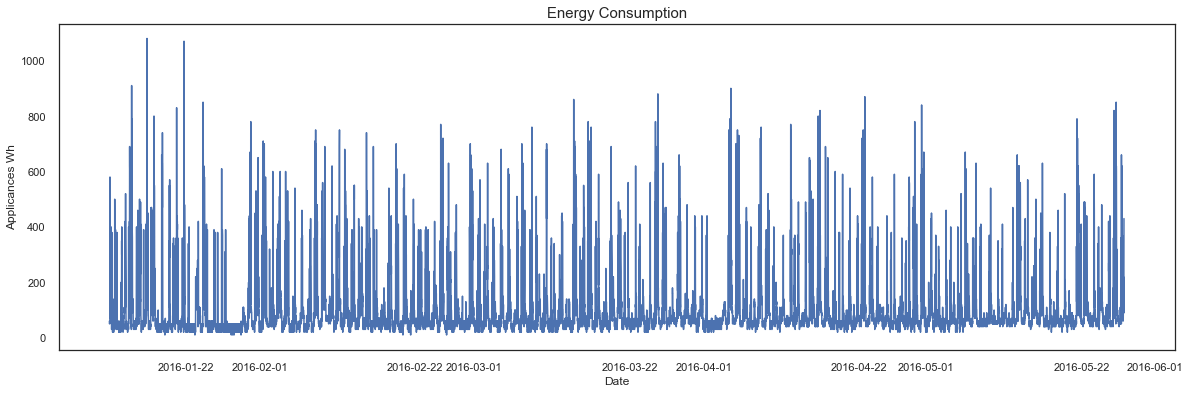

In [36]:
plt.figure(figsize = (20,6))
sns.lineplot(x = 'date', y = 'Appliances', data = energy).set(xlabel = 'Date', ylabel = 'Applicances Wh')
plt.title('Energy Consumption', size = 15)

We can observe multiple spikes in the data which means increased energy consumption during certain dates. We also take a closer look at the first week of data below.

Text(0.5, 1.0, 'Energy Consumption for Week 1')

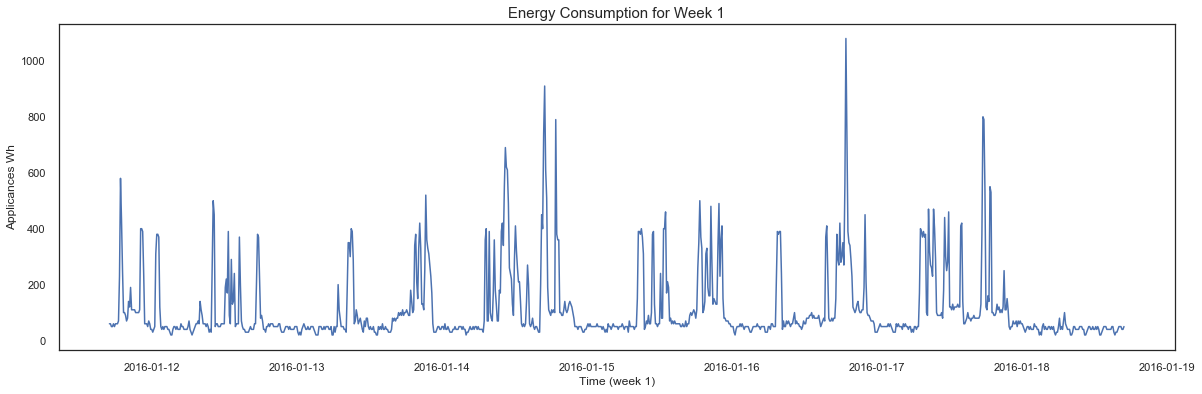

In [37]:
plt.figure(figsize = (20, 6))
sns.lineplot(x = energy.date[0:1008], y = energy.Appliances[0:1008]).set(xlabel = 'Time (week 1)', ylabel = 'Applicances Wh')
plt.title('Energy Consumption for Week 1', size = 15)

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64

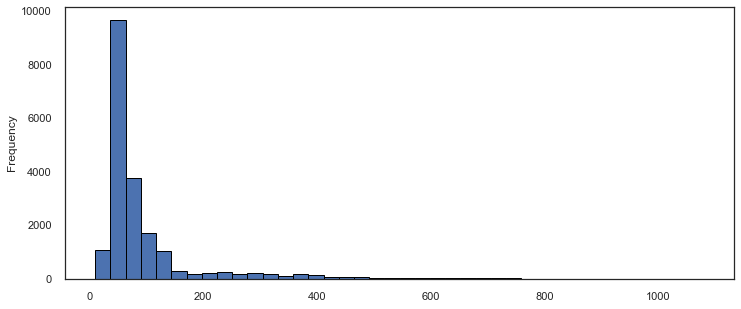

In [38]:
plt.figure(figsize=(12, 5))
energy.Appliances.plot.hist(edgecolor = 'black', bins = 40)
energy.Appliances.describe()

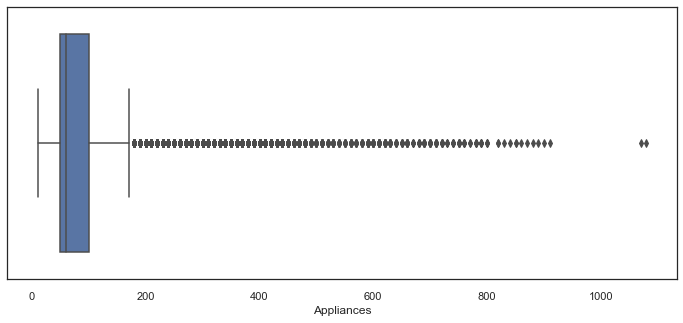

In [39]:
plt.figure(figsize=(12, 5))
sns.boxplot(energy.Appliances)

The energy consumption data is highly skewed to the right, as seen on the histogram and boxplots below, having average Wh higher than the median Wh. The average energy consumption is 97.69 Wh and 50% of the data have higher than 60 Wh usage.

## A Quick Glance at Hourly Energy Consumption
We transform our dataset to round down to the nearest hour and aggregate the energy consumption by date and hour. We also create a weekday and week number variable for exploratory data analysis.

In [40]:
energy['mhr'] = energy.date.apply(lambda x: x.replace(second = 0, minute = 0))
energy_total_per_hour = pd.DataFrame(energy.groupby('mhr').sum().Appliances).reset_index()
energy_total_per_hour['day'] = energy_total_per_hour.mhr.dt.day_name().astype('category', categories = days, ordered = True)
energy_total_per_hour['week_no'] = (energy_total_per_hour.mhr + dt.timedelta(days = 3)).dt.week
energy_total_per_hour.head()

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


mhr  Appliances     day  week_no
0 2016-01-11 17:00:00         330  Monday        2
1 2016-01-11 18:00:00        1060  Monday        2
2 2016-01-11 19:00:00        1040  Monday        2
3 2016-01-11 20:00:00         750  Monday        2
4 2016-01-11 21:00:00         620  Monday        2

In [41]:
def weekly_heatmap(n, idx):
    df = energy_total_per_hour[energy_total_per_hour.week_no == n]
    df['hour'] = df.mhr.apply(lambda x: x.hour)
    fig = sns.heatmap(df.pivot('hour', 'day', 'Appliances'), cmap = 'YlOrRd', ax = axs[idx], vmax = 3600,
                      cbar_kws = {'shrink': 0.75, 'label': 'Appliances', 'orientation': 'horizontal'}).invert_yaxis()
    return fig

A subset (weeks 3 to 6) of the aggregated energy consumption by date and hour is plotted below using a heatmap with the day of the week on the x-axis and the hour of the day (0 being midnight) on the y-axis.

/Users/jvlpz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


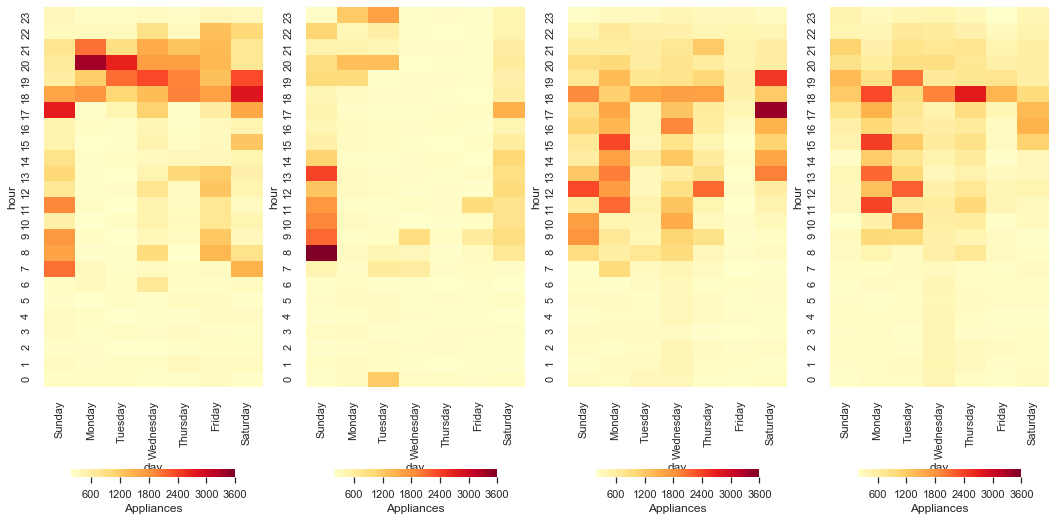

In [42]:
fig, axs = plt.subplots(ncols = 4, figsize=(18,10))

weekly_heatmap(3, 0)
weekly_heatmap(4, 1)
weekly_heatmap(5, 2)
weekly_heatmap(6, 3)

High energy consumption can be observed during the afernoon and night time, as well as the weekends which might be due to more appliance usage in the house as most family members are home during these times.

## Correlation Pair Plots between Appliances Energy Consumption
Next, we explore the correlation between the energy consumption of appliances and the rest of the variables. We'll define functions to speed up the creation of scatterplot and correlation matrices.

In [43]:
plot1_cols = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']
plot2_cols = ['Appliances', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6']
plot3_cols = ['Appliances', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
plot4_cols = ['Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'NSM']

In [44]:
def corr_plot(cols):
    df = energy[cols]
    fig = sns.PairGrid(df)
    fig.map_diag(plt.hist, bins = 15, edgecolor = "black")
    fig.map_lower(plt.scatter, edgecolor = "white", )
    fig.map_upper(corrdot)
    return fig

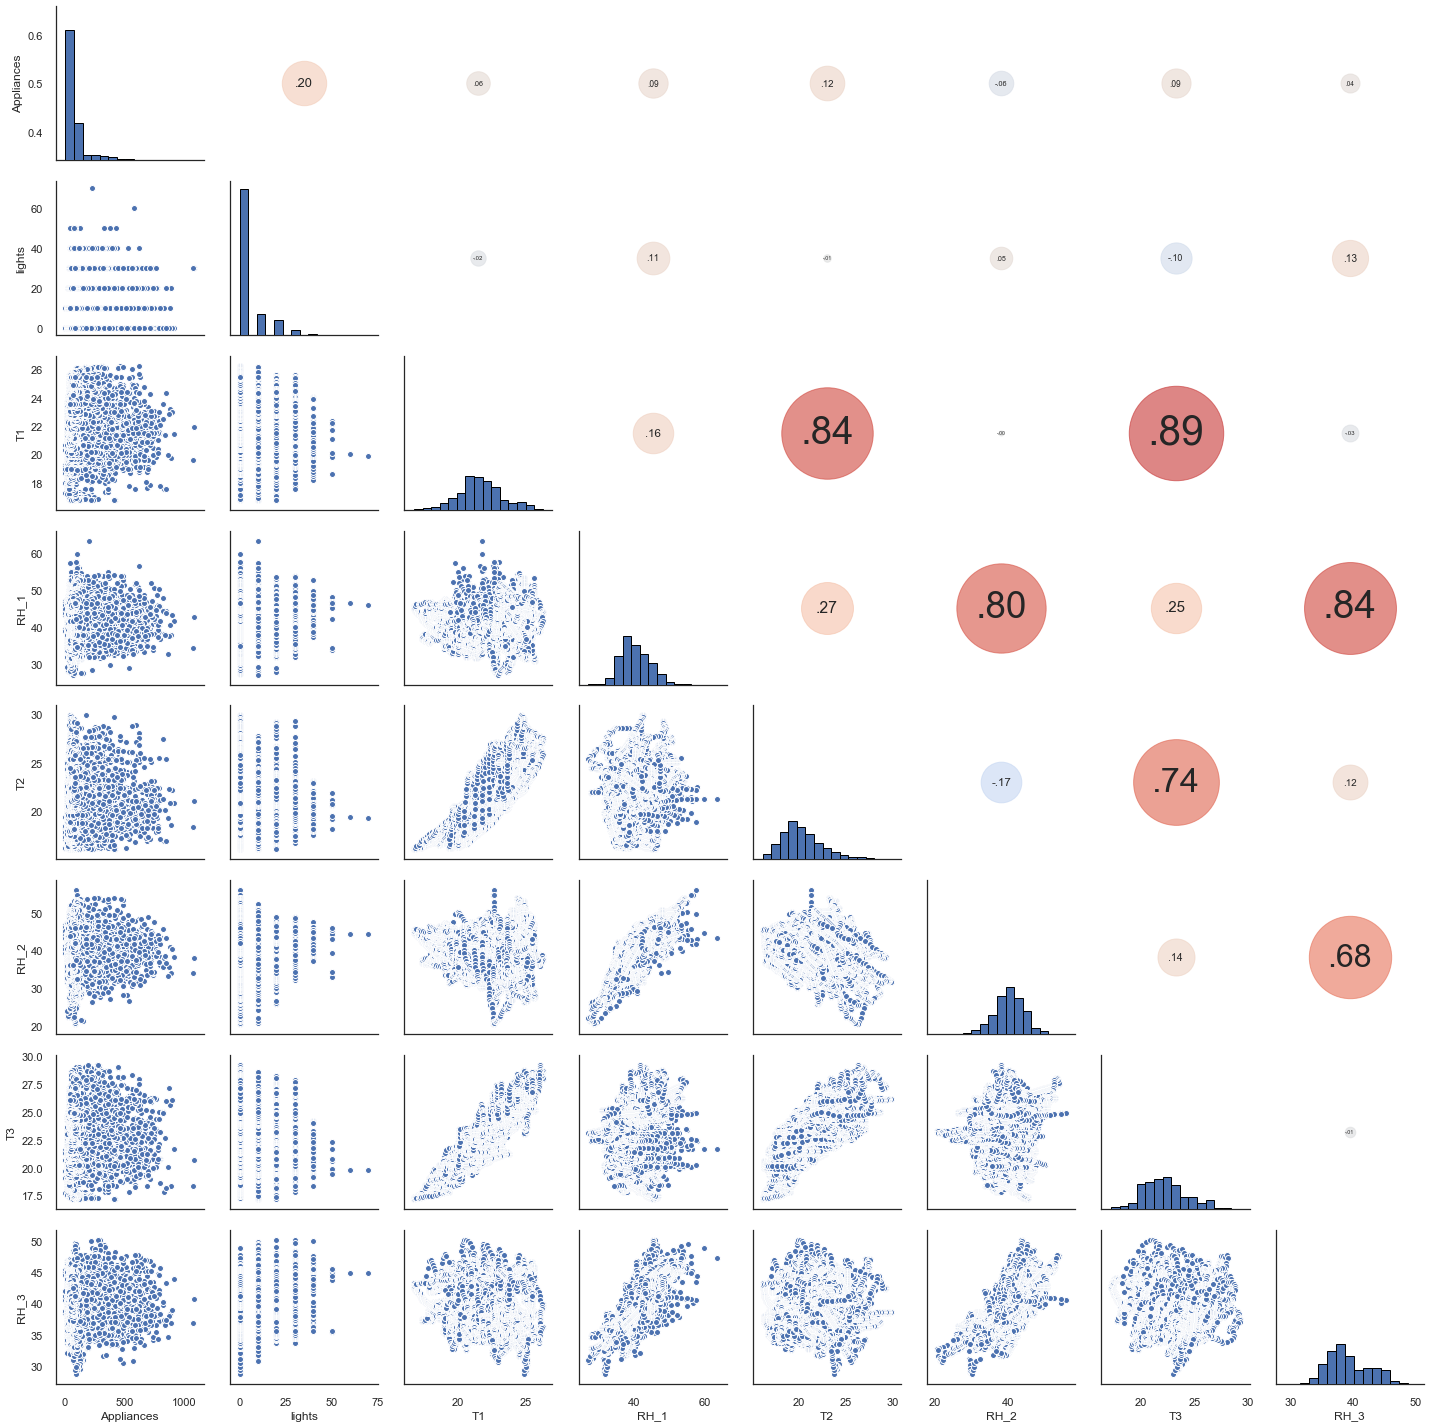

In [45]:
corr_plot(plot1_cols)

The correlation and scatter plot matrix above shows that there is a positive correlation between appliance energy consumption and lights, which means that higher appliance energy consumption is associated with higher lights consumption. The second largest correlation is between appliances and the temperature in the living room (T2). High positive correlation can be observed on temperature variable pairs and humidity variable pairs. The correlation and scatter plot matrices between energy consumption and the rest of the variables are presented on the succeeding cells.

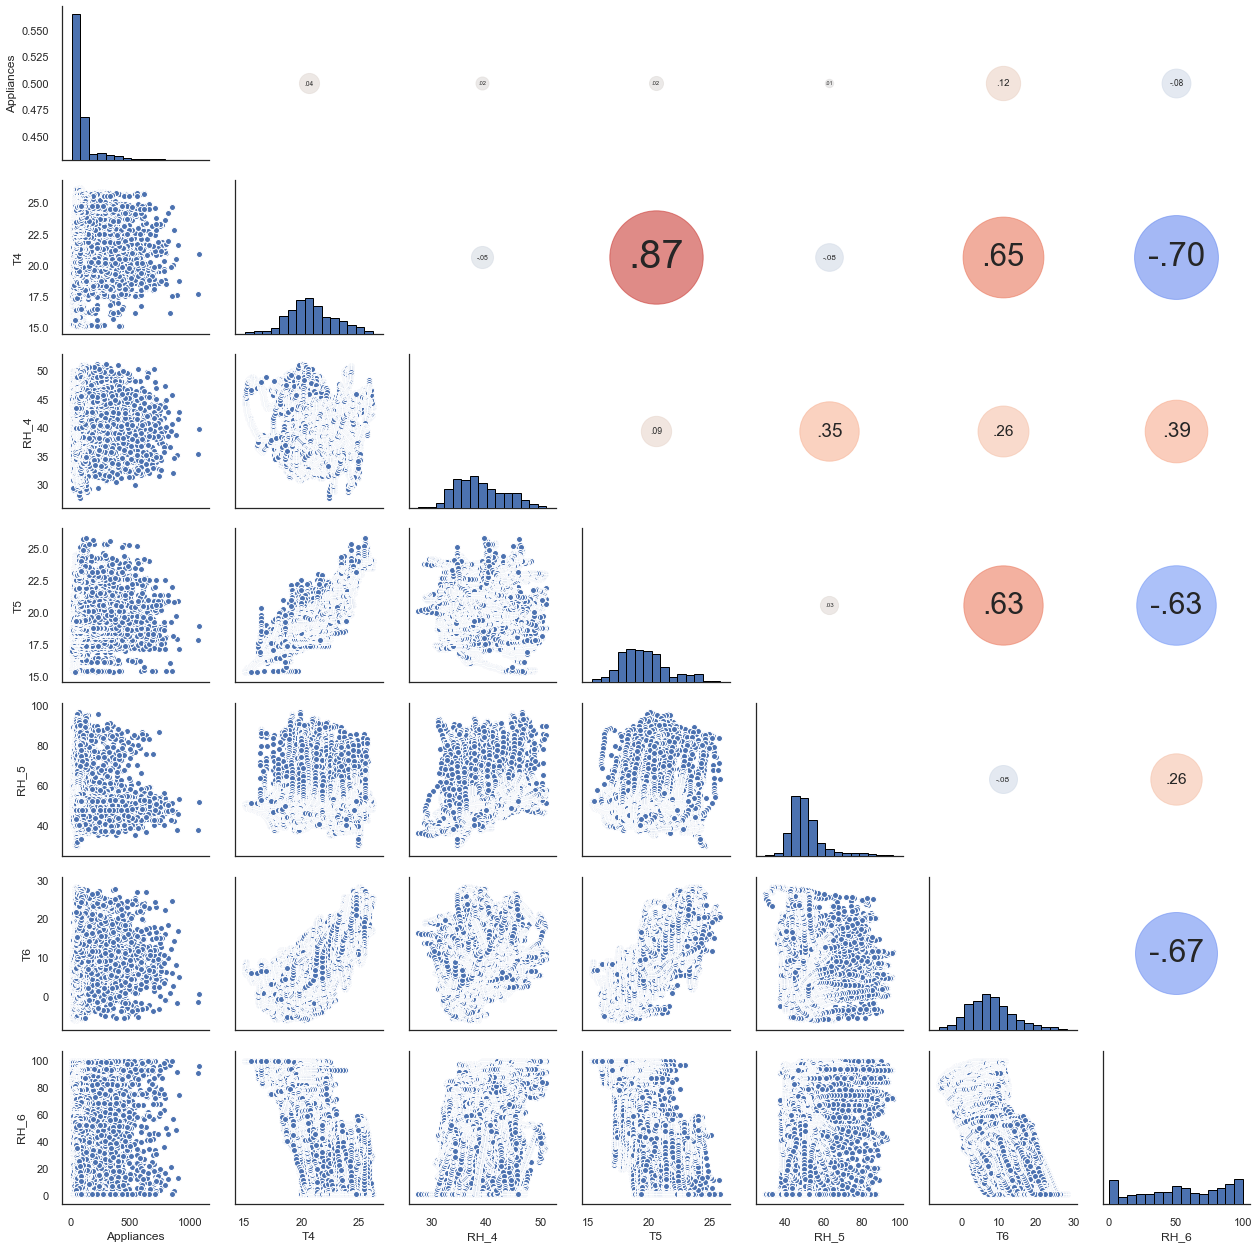

In [46]:
corr_plot(plot2_cols)

There is a positive correlation between energy consumption and outside temperature (T6). A negative correlation can be observed between energy consumption and outside humidity (RH_6). As observed on the previous plot matrix, a positive correlation can be observed on the temprature variable pairs, as well as humidity variable pairs.

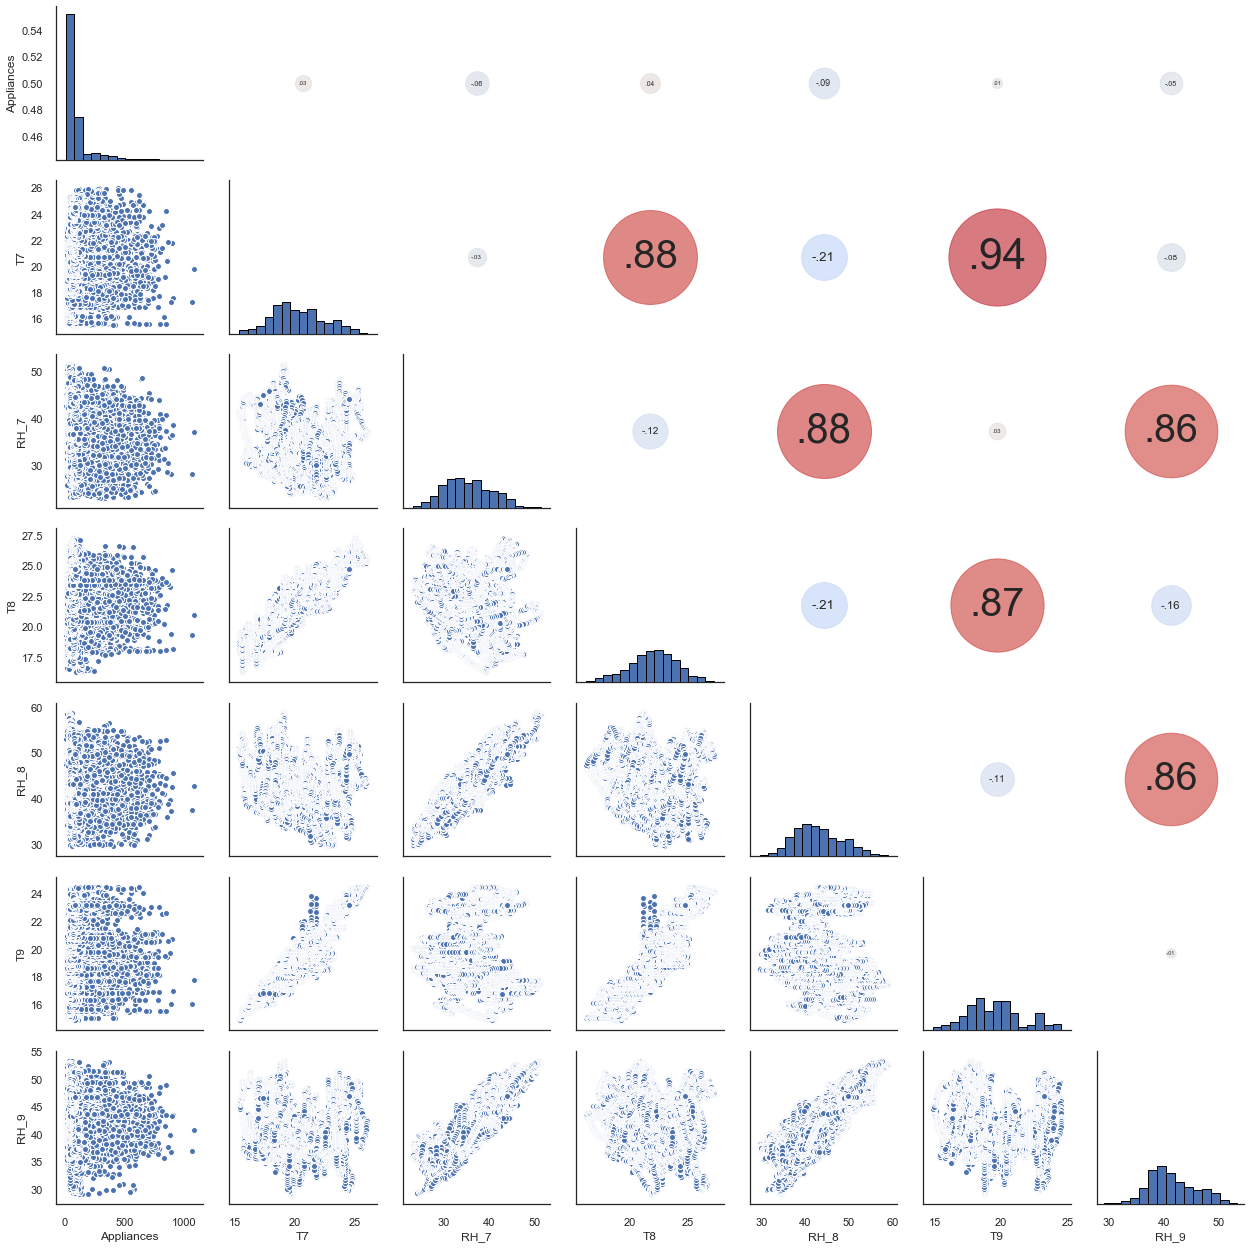

In [47]:
corr_plot(plot3_cols)

A positive correlation can be observed between energy consumption and the temperature in the ironing room (T7), the temperature in the teenager's room (T8) and the temperature in the parents' room. Again, temperature variable pairs and humidity variable pairs are also highly positively correlated.

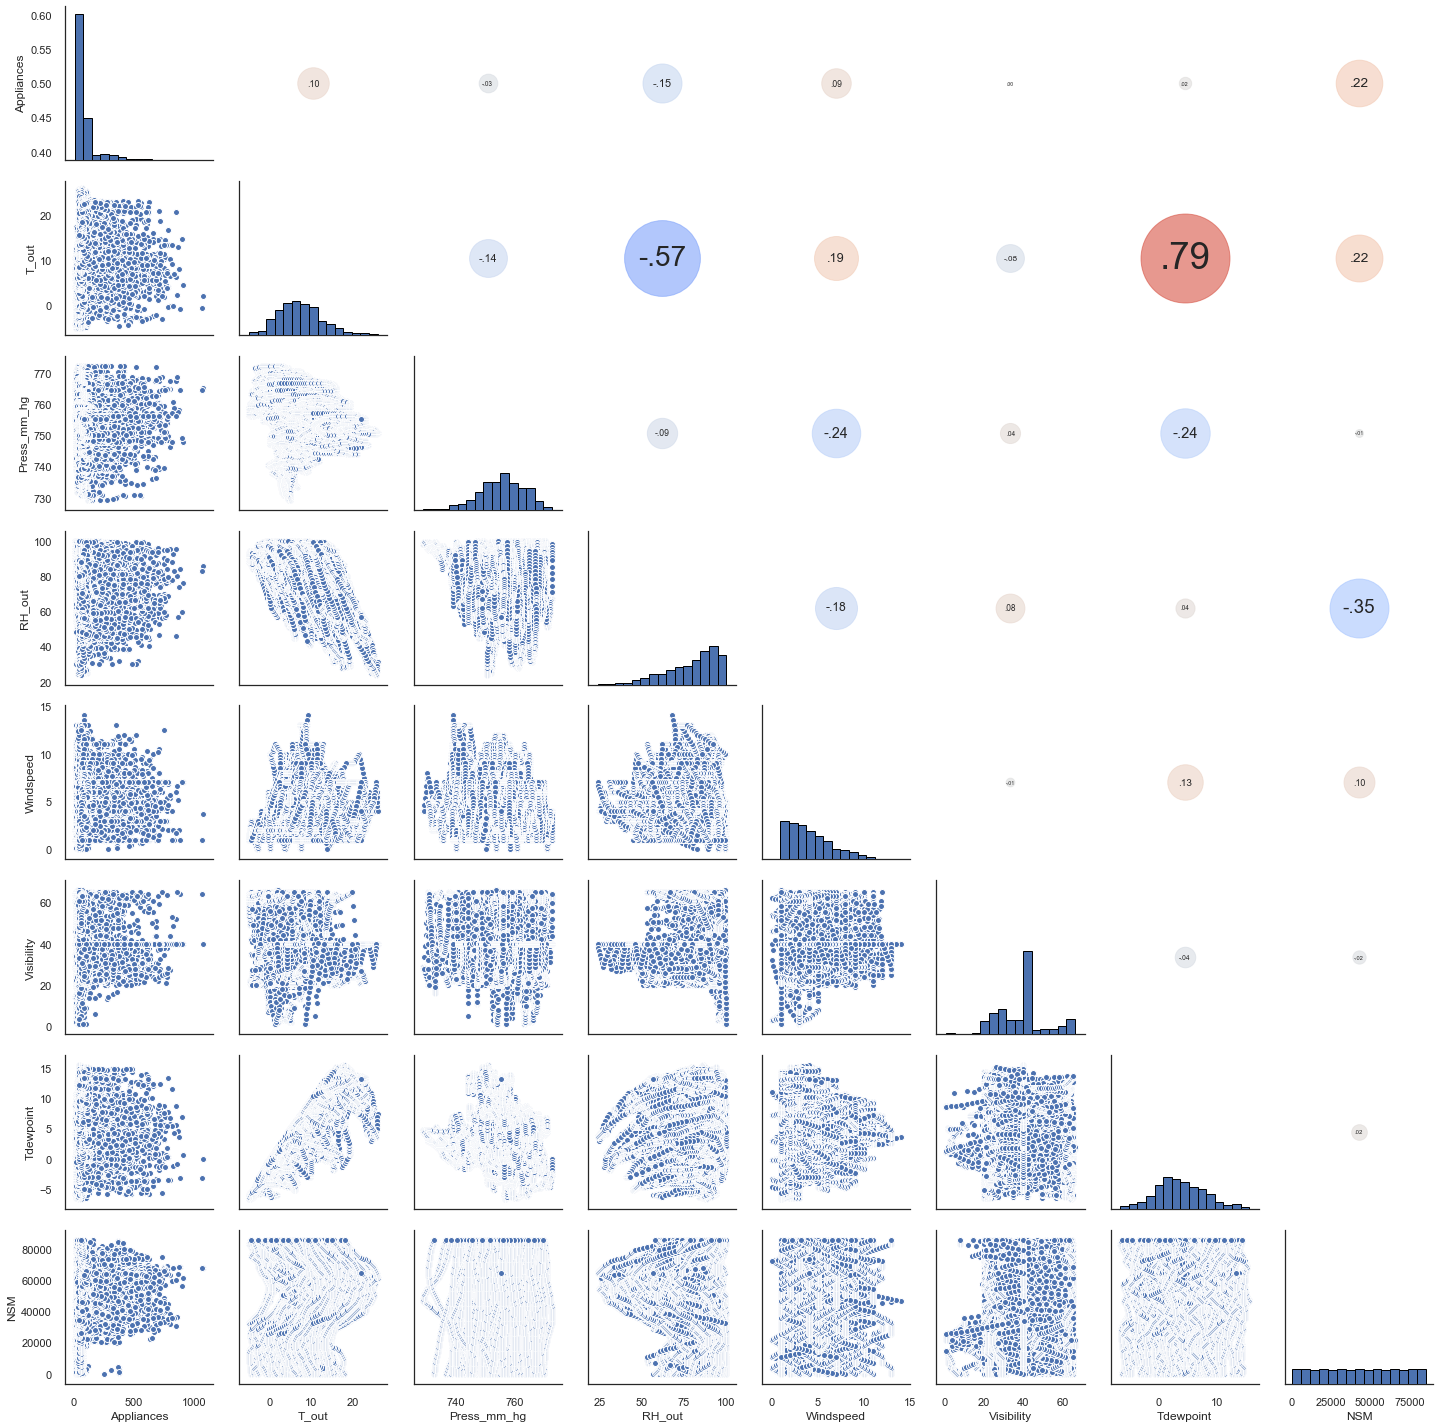

In [48]:
corr_plot(plot4_cols)

The number of seconds from midnight (NSM) has the highest positive correlation with appliance energy consumption. 

## Data Preparation for Multiple Regression Modelling with Recursive Feature Elimination
The training-test split is 75-25 which means the training dataset contains 14,803 observations and  testing dataset with 4,932 observations. We transform the week status and day of the week variables to categorical data and convert them to dummy variables in preparation for fitting the multiple linear regression. We also set the weekday value and Sunday value as reference variables for the week status and day of the week variables dummy data, respectively. We drop the variables `rv1` and `rv2` from our datasets since they are random variables.

In [49]:
train = pd.read_csv('data/training.csv')
train.date = pd.to_datetime(train.date)
test = pd.read_csv('data/testing.csv')
test.date = pd.to_datetime(train.date)
train = train.drop(['rv1', 'rv2'], axis = 1)
test = test.drop(['rv1', 'rv2'], axis = 1)
print("Dimensions of training dataset: ", train.shape)
print("Dimensions of testing dataset: ", test.shape)

Dimensions of training dataset:  (14803, 30)
Dimensions of testing dataset:  (4932, 30)


In [50]:
train['WeekStatus'] = train.WeekStatus.astype('category')
test['WeekStatus'] = test.WeekStatus.astype('category')
train['Day_of_week'] = train.Day_of_week.astype('category', categories = days, ordered = True)
test['Day_of_week'] = test.Day_of_week.astype('category', categories = days, ordered = True)

In [51]:
train_WeekStatus = pd.get_dummies(train.WeekStatus, drop_first = True)
test_WeekStatus = pd.get_dummies(test.WeekStatus, drop_first = True)
train_Day_of_week = pd.get_dummies(train.Day_of_week, drop_first = True)
test_Day_of_week = pd.get_dummies(test.Day_of_week, drop_first = True)
train = train.join(train_WeekStatus, how = "inner")
train = train.join(train_Day_of_week, how = "inner")
test = test.join(test_WeekStatus, how = "inner")
test = test.join(test_Day_of_week, how = "inner")

In [52]:
train = train.drop(['WeekStatus', 'Day_of_week'], axis = 1)
train.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0 2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1 2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2 2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3 2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4 2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4  ...  Visibility  Tdewpoint    NSM  Weekend  \
0  19.79  44.730000  19.000000  ...   63.000000        5.3  61200        0   
1  19.79  44.790000  19.000000  ...   59.166667        5.2  61800        0   
2  19.79  44.933333  18.926667  ...   55.333333        5.1  62400        0   
3  19.79  45.000000  18.890000  ...   47.666667        4.9  63600        0   
4  19.79  44.933333  18.890000  ...   43.833333        4.8  64200        0   

   Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  
0       1        0          0         0       0         0  
1       1        0          0         0       0         0  
2       1        0          0         0       0         0  
3       1        0          0         0       0         0  
4       1        0          0         0       0         0  

[5 rows x 35 columns]

In [53]:
test = test.drop(['WeekStatus', 'Day_of_week'], axis = 1)
test.head()

date  Appliances  lights         T1       RH_1         T2  \
0 2016-01-11 17:00:00          50      40  19.890000  46.066667  19.200000   
1 2016-01-11 17:10:00          60      50  19.890000  45.766667  19.200000   
2 2016-01-11 17:20:00         230      70  19.926667  45.863333  19.356667   
3 2016-01-11 17:40:00         580      60  20.066667  46.396667  19.426667   
4 2016-01-11 17:50:00         100      10  20.566667  53.893333  20.033333   

        RH_2     T3       RH_3     T4  ...  Visibility  Tdewpoint    NSM  \
0  44.590000  19.79  45.000000  18.89  ...        51.5   5.000000  63000   
1  44.500000  19.79  44.900000  18.89  ...        40.0   4.700000  64800   
2  44.400000  19.79  44.900000  18.89  ...        40.0   4.633333  67200   
3  44.400000  19.79  44.826667  19.00  ...        40.0   4.616667  67800   
4  46.756667  20.10  48.466667  19.00  ...        40.0   4.350000  70200   

   Weekend  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  
0        0       1        0          0         0       0         0  
1        0       1        0          0         0       0         0  
2        0       1        0          0         0       0         0  
3        0       1        0          0         0       0         0  
4        0       1        0          0         0       0         0  

[5 rows x 35 columns]

Finally, we specify the independent variables and the dependent variable that we will use when fitting the model. There are a total of 33 independent variables that we will use to predict the energy consumption through multiple regression model. We will simulate different number of covariates in the model by using the recursive feature elimination method to reduce the number of variables to the most important ones only.

In [54]:
X_cols = list(train.columns.drop(['date', 'Appliances']))
y_col = 'Appliances'
X_train = train[X_cols]
y_train = train[y_col]
X_test = test[X_cols]
y_test = test[y_col]

In [55]:
print('Dimension of X_train: ', X_train.shape)
print('Dimension of y_train: ', y_train.shape)
print('Dimension of X_test: ', X_test.shape)
print('Dimension of y_test: ', y_test.shape)

Dimension of X_train:  (14803, 33)
Dimension of y_train:  (14803,)
Dimension of X_test:  (4932, 33)
Dimension of y_test:  (4932,)


## Multiple Regression Model Training with Different Number of Predictors

We develop the multiple linear models with recursive feature elimination in the following section. We start with using only the top 5 most important predictors and increase the number of predictors by 5 in each iteration until we have included all predictors. In each of the model built, we will display the linear equation and the most important variables that were included in the model.

Prior to starting with building the multiple regression models, we define several functions that we will use for the rest of the analysis:

1. The `rfe_mlr` function provides a method to run the multiple linear regression algorithm with the recursive feature elimination.
2. The `list_rfe_pred` function displays the top `n` features selected by the RFE algorithm.
3. The `model_assess` function provides several model assessment metrics to compare the performance of each regression runs. The `print_assess` function displays the model assessment metrics results in each model. The following are used to assess the models:
    * __Root Mean Square Error__ (RMSE) is the square root of the variance of the residuals and measures how close/far the predicted values are from the actual values. Lower values of RMSE indicate that the predicted values are close to the actual values.
    * __Coefficient of Determination__ ($R^2$) measures how much of the variation in the response variable is explained by the linear model. Higher values of $R^2$ mean that the model explains most of the variability on the response variable.
    * __Mean Absolute Error__ (MAE) measures the average magnitude of deviation of the predicted values from the actual values without considering the direction of the error.
    * __Mean Absolute Percentage Error__ (MAPE) measures the average deviation of the predicted values from the actual values as a percentage.
    
The comparison of assessment metrics for all the models built will be discussed in the last part of the Portfolio 2 section.

In [56]:
def rfe_mlr(n, df_X, df_y):
    model = linear_model.LinearRegression()
    rfe = RFE(estimator = model, n_features_to_select = n, step = 1)
    rfe.fit(X_train, y_train)
    return rfe

def list_rfe_pred(model, df_X):
    features_bool = np.array(model.support_)
    features = np.array(df_X.columns)
    result = features[features_bool]
    return result

def model_assess(model, df_X, df_y):
    y_pred = model.predict(df_X)
    rmse = np.sqrt(((np.array(df_y) - y_pred)**2).sum() / len(df_y))
    r2 = r2_score(df_y, y_pred)
    mae = np.mean(abs((df_y - y_pred)))
    mape = np.mean(abs((df_y - y_pred) / df_y)) * 100
    return rmse, r2, mae, mape

def print_assess(model):
    print('RMSE: ', model[0])
    print('R-squared: ', model[1])
    print('Mean Absolute Error: ', model[2])
    print('Mean Absolute Percentage Error: ', model[3])

## Train Multiple Linear Regression Using 5 Most Important Variable

In [57]:
model5 = rfe_mlr(5, X_train, y_train)
print(list_rfe_pred(model5, X_train))

['RH_1' 'T2' 'RH_2' 'T3' 'Monday']


In [58]:
print("y = x *", model5.estimator_.coef_, "+", model5.estimator_.intercept_)

y = x * [ 19.42964585 -21.99191421 -19.93549145  18.09426842  13.10502611] + 163.98990561799167


Recursive feature algorithm has selected the following top 5 most important variables to be included in the model:
* kitchen humidity (RH_1)
* living room temperature (T2)
* living room humidity (RH_2)
* laundry room temperature (T3)
* Monday dummy variable (Monday)

### Assessing the Model on Training and Testing Dataset (5 Best Predictors)

In [59]:
model5_train_assess = model_assess(model5, X_train, y_train)
print_assess(model5_train_assess)

RMSE:  98.03949637444838
R-squared:  0.09090652238803942
Mean Absolute Error:  58.09424481326967
Mean Absolute Percentage Error:  71.5803343868902


In [60]:
model5_test_assess = model_assess(model5, X_test, y_test)
print_assess(model5_test_assess)

RMSE:  97.8787777388879
R-squared:  0.07198025464301383
Mean Absolute Error:  56.62988482233168
Mean Absolute Percentage Error:  69.63293227457307


## Train Multiple Linear Regression Using 10 Most Important Variable

In [61]:
model10 = rfe_mlr(10, X_train, y_train)
print(list_rfe_pred(model10, X_train))

['RH_1' 'T2' 'RH_2' 'T3' 'T8' 'RH_8' 'T9' 'Monday' 'Friday' 'Saturday']


In [62]:
print("y = x *", model10.estimator_.coef_, "+", model10.estimator_.intercept_)

y = x * [ 19.42674368 -12.86809623 -13.46086313  23.71033697   9.01043391
  -5.98461574 -23.37644956  14.462186    13.22100319  18.89599627] + 100.87057734084114


The following 5 variables were added as most important variables (on top of the 5 variables stated above) and were included in creation of the model:
* teenager's room temperature (T8)
* teenager's room humidity (RH_8)
* parents' room temperature (T9)
* Friday dummy variable (Friday)
* Saturday dummy variable (Saturday)

### Assessing the Model on Training and Testing Dataset (10 Best Predictors)

In [63]:
model10_train_assess = model_assess(model10, X_train, y_train)
print_assess(model10_train_assess)

RMSE:  95.2334633730318
R-squared:  0.1422009597443512
Mean Absolute Error:  54.16099668526507
Mean Absolute Percentage Error:  63.41034270141491


In [64]:
model10_test_assess = model_assess(model10, X_test, y_test)
print_assess(model10_test_assess)

RMSE:  95.04617607469439
R-squared:  0.12491661191575232
Mean Absolute Error:  52.71066575069968
Mean Absolute Percentage Error:  61.6491199458991


## Train Multiple Linear Regression Using 15 Most Important Variable

In [65]:
model15 = rfe_mlr(15, X_train, y_train)
print(list_rfe_pred(model15, X_train))

['RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T6' 'T8' 'RH_8' 'T9' 'T_out' 'Monday'
 'Tuesday' 'Thursday' 'Friday' 'Saturday']


In [66]:
print("y = x *", model15.estimator_.coef_, "+", model15.estimator_.intercept_)

y = x * [ 16.91712633 -18.14925372 -14.16643357  24.14993638   5.91150563
   6.04890301  11.82985876  -6.75950867 -22.86800603  -5.29081629
  10.69939111  -6.45314955  -4.59550365  11.95655142  16.55213327] + 51.27516044333392


The following 5 variables were added as most important variables (on top of the 10 variables stated above) and were included in creation of the model:
* laundry room humidity (RH_3)
* temperature outside the building (T6)
* temperature outside (from weather station) (T_out)
* Tuesday dummy variable (Tuesday)
* Thursday dummy variable (Thursday)

### Assessing the Model on Training and Testing Dataset (15 Best Predictors)

In [67]:
model15_train_assess = model_assess(model15, X_train, y_train)
print_assess(model15_train_assess)

RMSE:  94.74081714345569
R-squared:  0.1510528571205575
Mean Absolute Error:  54.111842827035794
Mean Absolute Percentage Error:  63.70311480945067


In [68]:
model15_test_assess = model_assess(model15, X_test, y_test)
print_assess(model15_test_assess)

RMSE:  94.68431856934916
R-squared:  0.13156712061088804
Mean Absolute Error:  52.80595714685305
Mean Absolute Percentage Error:  61.952778069711556


## Train Multiple Linear Regression Using 20 Most Important Variable

In [69]:
model20 = rfe_mlr(20, X_train, y_train)
print(list_rfe_pred(model20, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T6' 'RH_7' 'T8' 'RH_8' 'T9'
 'T_out' 'Windspeed' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday'
 'Saturday']


In [70]:
print("y = x *", model20.estimator_.coef_, "+", model20.estimator_.intercept_)

y = x * [  2.00608255  -3.76086189  15.34984826 -17.01613045 -13.59121462
  24.35566676   6.20548505   5.90589538  -1.47605436   9.80646357
  -5.20451753 -16.69565747  -5.31516504   1.73792697   4.85692424
  -8.44337978  -5.12342324  -5.56614619  13.15047689  16.62693377] + 31.842356511565995


The following 5 variables were added as most important variables (on top of the 15 variables stated above) and were included in creation of the model:
* light energy consumption (lights)
* kitchen temperature (T1)
* ironing room humidity (RH_7)
* windspeed (from weather station) (Windspeed)
* Wednesday dummy variable (Wednesday)

### Assessing the Model on Training and Testing Dataset (20 Best Predictors)

In [71]:
model20_train_assess = model_assess(model20, X_train, y_train)
print_assess(model20_train_assess)

RMSE:  93.44959349975872
R-squared:  0.17403578521951757
Mean Absolute Error:  53.264090357624596
Mean Absolute Percentage Error:  61.36610007463241


In [72]:
model20_test_assess = model_assess(model20, X_test, y_test)
print_assess(model20_test_assess)

RMSE:  93.29369806417367
R-squared:  0.15688899404690926
Mean Absolute Error:  52.0435349167842
Mean Absolute Percentage Error:  59.93206643746938


## Train Multiple Linear Regression Using 25 Most Important Variable

In [73]:
model25 = rfe_mlr(25, X_train, y_train)
print(list_rfe_pred(model25, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T5' 'T6' 'T7' 'RH_7' 'T8'
 'RH_8' 'T9' 'RH_9' 'T_out' 'Windspeed' 'Tdewpoint' 'Weekend' 'Monday'
 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']


In [74]:
print("y = x *", model25.estimator_.coef_, "+", model25.estimator_.intercept_)

y = x * [  1.97507276  -3.83559432  15.31223233 -16.88550846 -13.84256667
  24.55940416   6.8508383   -0.82002521   5.71111893   1.29635931
  -1.6811772    9.2812778   -5.00602161 -17.08648494  -0.81805578
  -5.69377607   1.85555477   1.13326664   0.40682642   5.51062794
  -8.35077265  -5.0642284   -5.28235437  12.77990106  16.56219322] + 53.84059444701212


The following 5 variables were added as most important variables (on top of the 20 variables stated above) and were included in creation of the model:
* bathroom temperature (T5)
* ironing room temperature (T7)
* parents' room humidity (RH_9)
* Tdewpoint (from weather station) (Tdewpoint)
* weekend dummy variable (Weekend)

### Assessing the Model on Training and Testing Dataset (25 Best Predictors)

In [75]:
model25_train_assess = model_assess(model25, X_train, y_train)
print_assess(model25_train_assess)

RMSE:  93.4268109316125
R-squared:  0.17443846845195932
Mean Absolute Error:  53.19346168254047
Mean Absolute Percentage Error:  61.27138211502101


In [76]:
model25_test_assess = model_assess(model25, X_test, y_test)
print_assess(model25_test_assess)

RMSE:  93.3248817812589
R-squared:  0.15632527474736035
Mean Absolute Error:  52.02423852826069
Mean Absolute Percentage Error:  59.89604005172939


## Train Multiple Linear Regression Using 30 Most Important Variable

In [77]:
model30 = rfe_mlr(30, X_train, y_train)
print(list_rfe_pred(model30, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T4' 'T5' 'T6' 'RH_6' 'T7'
 'RH_7' 'T8' 'RH_8' 'T9' 'RH_9' 'T_out' 'Press_mm_hg' 'RH_out' 'Windspeed'
 'Visibility' 'Tdewpoint' 'Weekend' 'Monday' 'Tuesday' 'Wednesday'
 'Thursday' 'Friday' 'Saturday']


In [78]:
print("y = x *", model30.estimator_.coef_, "+", model30.estimator_.intercept_)

y = x * [  1.94290884  -4.39841065  15.16579083 -17.35599317 -13.88456284
  25.60342909   6.49000317   0.54481653  -0.50018062   6.6382181
   0.2944557    1.28874777  -1.62575955   9.33024488  -4.98954663
 -15.99119412  -1.11476818  -9.96111189   0.17464299  -1.02125135
   1.72675781   0.18248413   4.9230191    1.06820614   5.32521402
  -8.61881019  -4.86671029  -5.23567182  12.32777212  16.66098599] + -19.09938744195675


The following 5 variables were added as most important variables (on top of the 25 variables stated above) and were included in creation of the model:
* office room temperature (T4)
* humidity outside (RH_6)
* pressure (from weather station) (Press_mm_hg)
* humidity outside (from weather station) (RH_out)
* visibility (from weather station) (Visibility)

### Assessing the Model on Training and Testing Dataset (30 Best Predictors)

In [79]:
model30_train_assess = model_assess(model30, X_train, y_train)
print_assess(model30_train_assess)

RMSE:  93.34689033201167
R-squared:  0.17585029341753777
Mean Absolute Error:  53.17076583609735
Mean Absolute Percentage Error:  61.30486435032356


In [80]:
model30_test_assess = model_assess(model30, X_test, y_test)
print_assess(model30_test_assess)

RMSE:  93.29808618950878
R-squared:  0.15680967971270277
Mean Absolute Error:  52.04583943459271
Mean Absolute Percentage Error:  59.98923927309118


## Train Multiple Linear Regression Using All Variables

In [81]:
model_all = rfe_mlr(35, X_train, y_train)
print(list_rfe_pred(model_all, X_train))

['lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T4' 'RH_4' 'T5' 'RH_5' 'T6'
 'RH_6' 'T7' 'RH_7' 'T8' 'RH_8' 'T9' 'RH_9' 'T_out' 'Press_mm_hg' 'RH_out'
 'Windspeed' 'Visibility' 'Tdewpoint' 'NSM' 'Weekend' 'Monday' 'Tuesday'
 'Wednesday' 'Thursday' 'Friday' 'Saturday']


In [82]:
print("y = x *", model_all.estimator_.coef_, "+", model_all.estimator_.intercept_)

y = x * [ 1.85514349e+00 -5.91623712e+00  1.45115663e+01 -1.78907829e+01
 -1.38360616e+01  2.63682598e+01  6.28860382e+00  9.24488963e-01
 -4.84922719e-01 -1.46004124e+00  6.80289266e-02  7.07362501e+00
  2.90309897e-01  1.41094452e+00 -1.62558312e+00  8.34559362e+00
 -4.13546815e+00 -1.30500097e+01 -3.80092173e-01 -9.70071004e+00
  1.80488089e-01 -7.82451548e-01  1.78827983e+00  1.87709260e-01
  3.63247626e+00  2.88265474e-04  1.29517599e+00  5.65557106e+00
 -8.48582427e+00 -5.00934073e+00 -5.26637963e+00  1.18107976e+01
  1.63015281e+01] + -75.2181843328019


The last 3 variables added in our final iteration which includes all predictor variables are:
* office room humidity (RH_4)
* bathroom humidity (RH_5)
* number of seconds from midnight (NSM)

### Assessing the Model on Training and Testing Dataset (All Predictors)

In [83]:
model_all_train_assess = model_assess(model_all, X_train, y_train)
print_assess(model_all_train_assess)

RMSE:  93.20818501242448
R-squared:  0.17829770259775424
Mean Absolute Error:  53.13413548775942
Mean Absolute Percentage Error:  61.32090138994758


In [84]:
model_all_test_assess = model_assess(model_all, X_test, y_test)
print_assess(model_all_test_assess)

RMSE:  93.17607638358301
R-squared:  0.15901358813014577
Mean Absolute Error:  51.97453623832735
Mean Absolute Percentage Error:  59.93542814904038


## Summary of Model Assessment Metrics on Training and Testing Datasets
 
We combine the result of each model performance against one another. We create separate tables for model assessment metrics on the training (`model_comparison_train`) and testing (`model_comparison_test`) datasets.

In [85]:
model_comparison_train = pd.DataFrame(['Root Mean Square Error', 'R-squared', 'Mean Absolute Error', 'Mean Absolute Percentage Error'])
model_comparison_train['5 Variables'] = pd.DataFrame(model5_train_assess)
model_comparison_train['10 Variables'] = pd.DataFrame(model10_train_assess)
model_comparison_train['15 Variables'] = pd.DataFrame(model15_train_assess)
model_comparison_train['20 Variables'] = pd.DataFrame(model20_train_assess)
model_comparison_train['25 Variables'] = pd.DataFrame(model25_train_assess)
model_comparison_train['30 Variables'] = pd.DataFrame(model30_train_assess)
model_comparison_train['All Variables'] = pd.DataFrame(model_all_train_assess)
model_comparison_train.rename(columns={0:'Metric (Training Dataset)'}, inplace = True)

In [86]:
model_comparison_test = pd.DataFrame(['Root Mean Square Error', 'R-squared', 'Mean Absolute Error', 'Mean Absolute Percentage Error'])
model_comparison_test['5 Variables'] = pd.DataFrame(model5_test_assess)
model_comparison_test['10 Variables'] = pd.DataFrame(model10_test_assess)
model_comparison_test['15 Variables'] = pd.DataFrame(model15_test_assess)
model_comparison_test['20 Variables'] = pd.DataFrame(model20_test_assess)
model_comparison_test['25 Variables'] = pd.DataFrame(model25_test_assess)
model_comparison_test['30 Variables'] = pd.DataFrame(model30_test_assess)
model_comparison_test['All Variables'] = pd.DataFrame(model_all_test_assess)
model_comparison_test.rename(columns={0:'Metric (Testing Dataset)'}, inplace = True)

In [87]:
model_comparison_train

Metric (Training Dataset)  5 Variables  10 Variables  15 Variables  \
0          Root Mean Square Error    98.039496     95.233463     94.740817   
1                       R-squared     0.090907      0.142201      0.151053   
2             Mean Absolute Error    58.094245     54.160997     54.111843   
3  Mean Absolute Percentage Error    71.580334     63.410343     63.703115   

   20 Variables  25 Variables  30 Variables  All Variables  
0     93.449593     93.426811     93.346890      93.208185  
1      0.174036      0.174438      0.175850       0.178298  
2     53.264090     53.193462     53.170766      53.134135  
3     61.366100     61.271382     61.304864      61.320901

In [88]:
model_comparison_test

Metric (Testing Dataset)  5 Variables  10 Variables  15 Variables  \
0          Root Mean Square Error    97.878778     95.046176     94.684319   
1                       R-squared     0.071980      0.124917      0.131567   
2             Mean Absolute Error    56.629885     52.710666     52.805957   
3  Mean Absolute Percentage Error    69.632932     61.649120     61.952778   

   20 Variables  25 Variables  30 Variables  All Variables  
0     93.293698     93.324882     93.298086      93.176076  
1      0.156889      0.156325      0.156810       0.159014  
2     52.043535     52.024239     52.045839      51.974536  
3     59.932066     59.896040     59.989239      59.935428

As we add more predictors in the model, the root mean square error, mean absolute error and mean percentage error tend to go lower which means that the predicted values get closer to the actual values on average. On the other hand, R-squared values go higher as we add more predictors to the model, however the values are not significant enough for us to conclude that our linear models are good predictors of energy consumption. While our models perform better each time we add more variables to them, the model diagnostics shows small marginal improvements. The largest improvement was observed when we increased the number of predictors from 5 variables to 10 variables. Adding more predictors thereafter only brought very little improvement. The research paper discusses a number of different machine learning algorithms that perform better in predicting energy comsumption than the multiple linear regression. These algorithms are not discussed as they go beyond the scope of this notebook.

# Portfolio 3: Clustering Visualisation

K-means clustering is one of the simplest and popular unsupervised learning algorithms. Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes. This notebook illustrates the process of K-means clustering by generating some random clusters of data and then showing the iterations of the algorithm as random cluster means are updated. 

We first generate random data around 4 centers.

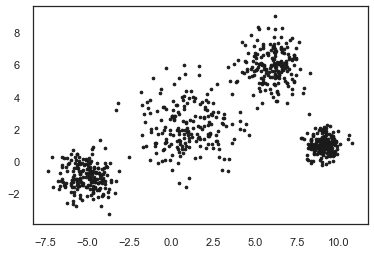

In [89]:
center_1 = np.array([1,2])
center_2 = np.array([6,6])
center_3 = np.array([9,1])
center_4 = np.array([-5,-1])

# Generate random data and center it to the four centers each with a different variance
np.random.seed(5)
data_1 = np.random.randn(200,2) * 1.5 + center_1
data_2 = np.random.randn(200,2) * 1 + center_2
data_3 = np.random.randn(200,2) * 0.5 + center_3
data_4 = np.random.randn(200,2) * 0.8 + center_4

data = np.concatenate((data_1, data_2, data_3, data_4), axis = 0)

plt.scatter(data[:,0], data[:,1], s=7, c='k')
plt.show()

## 1. Generate random cluster centres

You need to generate four random centres.

This part of portfolio should contain at least:  
- The number of clusters `k` is set to 4;
- Generate random centres via `centres = np.random.randn(k,c)*std + mean` where `std` and `mean` are the standard deviation and mean of the data. `c` represents the number of features in the data. Set the random seed to 6.
- Color the generated centers with `green`, `blue`, `yellow`, and `cyan`. Set the edgecolors to `red`.

In [90]:
k = 4
c = 2
mean = data.mean()
std = data.std()
np.random.seed(6)
centres = np.random.randn(k, c) * std + mean

In [91]:
centres_df = pd.DataFrame(centres)
centres_df

0         1
0  1.043017  5.538637
1  3.330612 -1.493825
2 -8.351752  6.334483
3  7.258032 -4.150287

In [92]:
data_df = pd.DataFrame(data)
data_df.head()

0         1
0  1.661841  1.503695
1  4.646157  1.621862
2  1.164415  4.373722
3 -0.363849  1.112545
4  1.281405  1.505195

Define the following functions to be used in the K-means algorithm:
* __Euclidean distance calculation__ - Use Pythagorean Theorem to compute the distance between two points
* __Cluster tagging__ - Use the Euclidean distance function and calculate to which centroid the point is closest to
* __Recomputation of the new clusters__ - Recompute the new cluster centroids by getting the average of the x- and y-coordinates of each cluster

In [93]:
def euclidean_distance(a, b):
    return np.sqrt(((a - b)**2).sum())

def find_cluster(a, centroid):
    n = len(centroid)
    closest = 0
    min_dist = euclidean_distance(a, centroid.iloc[0])
    for i in range(1, n):
        dist = euclidean_distance(a, centroid.iloc[i])
        if dist < min_dist:
            min_dist = dist
            closest = i
    return closest

def recompute_centroid(df):
    return pd.DataFrame(data_df.groupby('cluster').mean())

## 2. Visualise the clustering results in each iteration

You need to implement the process of k-means clustering.  Implement each iteration as a seperate cell, assigning each data point to the closest centre, then updating the cluster centres based on the data, then plot the new clusters.

The K-means clustering algorithm is executed as follows:  
__Step 1__. Initialise the 4 random clusters generated (assign 4 colours for the clusters.  
__Step 2__. Compute the distance of each data point to each of the 4 clusters and assign the nearest cluster centre appropriate colour to that data point.  
__Step 3__. Recalculate the new cluster centres by getting the average of the x- and y-coordinates of the data points that belong to each of the current cluster centres.  
__Step 4__. Compute the Euclidean distance between the the old cluster centres and the new cluster centres. If the distance between each points of the two sets of clusters is very small (i.e., cluster centres barely moved) or no movement at all, then stop the algorithm, otherwise, repeat from Step 2.

In [94]:
colors = {0 : 'green',
          1 : 'blue',
          2 : 'yellow',
          3 : 'cyan'}
new_cluster_cntr = centres_df

In [95]:
def recompute_and_plot(centroid, recompute = False):
    data_df['cluster'] = data_df[[0, 1]].apply(lambda x: find_cluster(x, centroid), axis = 1)
    if recompute:
        centroid = recompute_centroid(data_df)
    plt.figure(figsize=(10, 7))
    dataset = sns.scatterplot(x = data_df[0], y = data_df[1], hue = data_df.cluster, palette = colors, legend = False)
    centroid = sns.scatterplot(x = centroid[0], y = centroid[1], hue = centroid.index, palette = colors, s = 75, edgecolor = 'r')
    return dataset, centroid

Text(0, 1.05, 'Initial State')

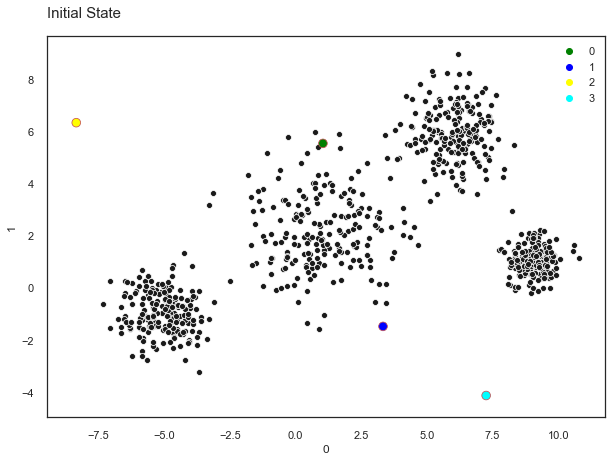

In [96]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x = data_df[0], y = data_df[1], color = 'k', legend = False)
sns.scatterplot(x = new_cluster_cntr[0], y = new_cluster_cntr[1], hue = new_cluster_cntr.index, palette = colors, s = 75, edgecolor = 'r')
plt.annotate('Initial State', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)

Text(0, 1.05, 'Iteration 0 (Compute Nearest Cluster)')

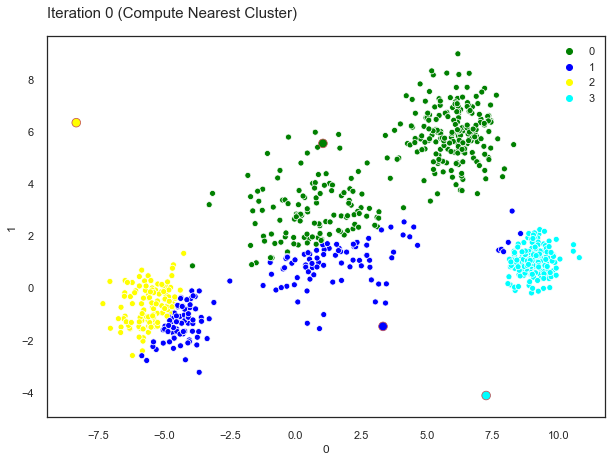

In [97]:
recompute_and_plot(new_cluster_cntr, recompute = False)
plt.annotate('Iteration 0 (Compute Nearest Cluster)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)

0    3.671697
1    5.758375
2    9.835599
3    3.336064
dtype: float64

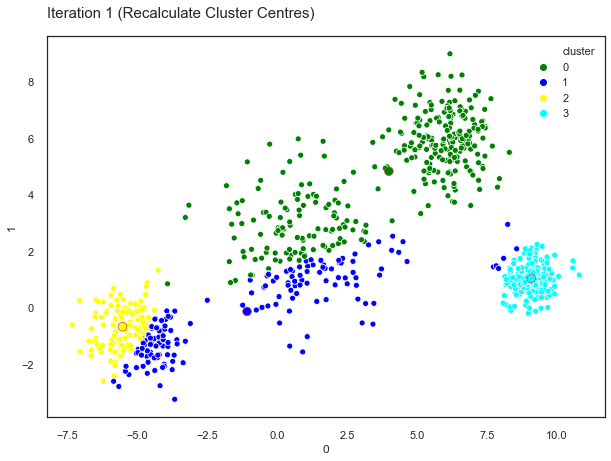

In [98]:
recompute_and_plot(new_cluster_cntr, recompute = True)
plt.annotate('Iteration 1 (Recalculate Cluster Centres)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)
old_cluster_cntr = new_cluster_cntr
new_cluster_cntr = recompute_centroid(data_df)
(old_cluster_cntr - new_cluster_cntr).apply(lambda x: euclidean_distance(x[0], x[1]), axis = 1)

Text(0, 1.05, 'Iteration 1 (Compute Nearest Cluster)')

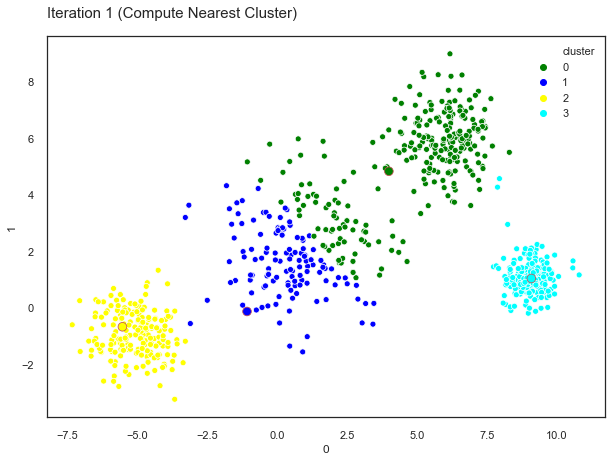

In [99]:
data_df['cluster'] = data_df[[0, 1]].apply(lambda x: find_cluster(x, new_cluster_cntr), axis = 1)
recompute_and_plot(new_cluster_cntr, recompute = False)
plt.annotate('Iteration 1 (Compute Nearest Cluster)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)

cluster
0    0.574942
1    0.363101
2    0.728501
3    0.099357
dtype: float64

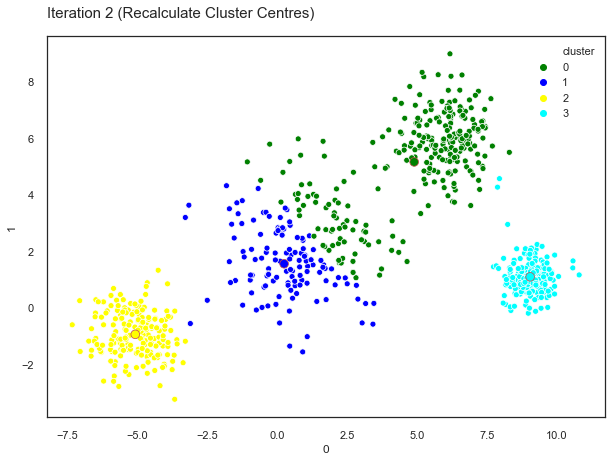

In [100]:
recompute_and_plot(new_cluster_cntr, recompute = True)
plt.annotate('Iteration 2 (Recalculate Cluster Centres)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)
old_cluster_cntr = new_cluster_cntr
new_cluster_cntr = recompute_centroid(data_df)
(old_cluster_cntr - new_cluster_cntr).apply(lambda x: euclidean_distance(x[0], x[1]), axis = 1)

Text(0, 1.05, 'Iteration 2 (Compute Nearest Cluster)')

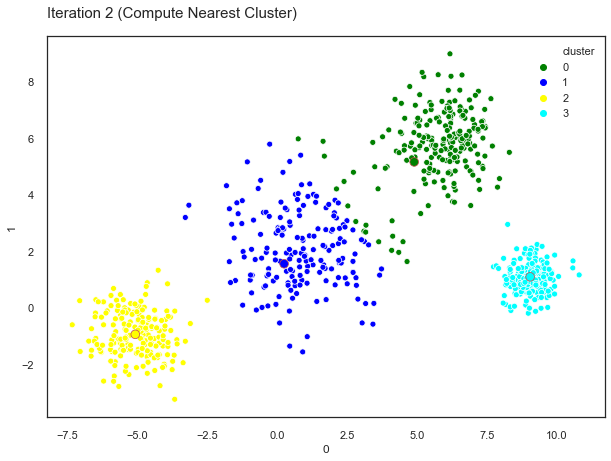

In [101]:
data_df['cluster'] = data_df[[0, 1]].apply(lambda x: find_cluster(x, new_cluster_cntr), axis = 1)
recompute_and_plot(new_cluster_cntr, recompute = False)
plt.annotate('Iteration 2 (Compute Nearest Cluster)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)

cluster
0    0.295795
1    0.036408
2    0.014635
3    0.044402
dtype: float64

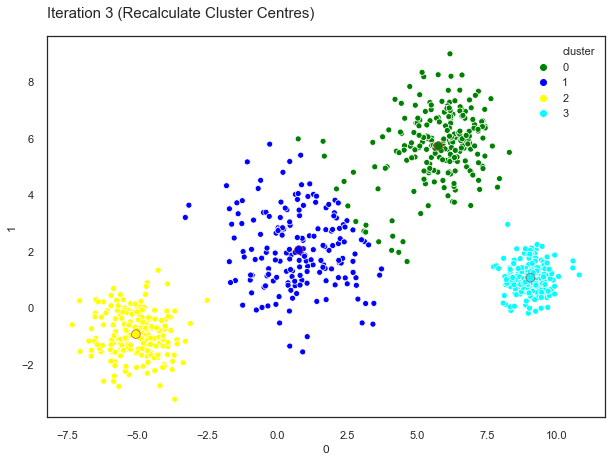

In [102]:
recompute_and_plot(new_cluster_cntr, recompute = True)
plt.annotate('Iteration 3 (Recalculate Cluster Centres)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)
old_cluster_cntr = new_cluster_cntr
new_cluster_cntr = recompute_centroid(data_df)
(old_cluster_cntr - new_cluster_cntr).apply(lambda x: euclidean_distance(x[0], x[1]), axis = 1)

Text(0, 1.05, 'Iteration 3 (Compute Nearest Cluster)')

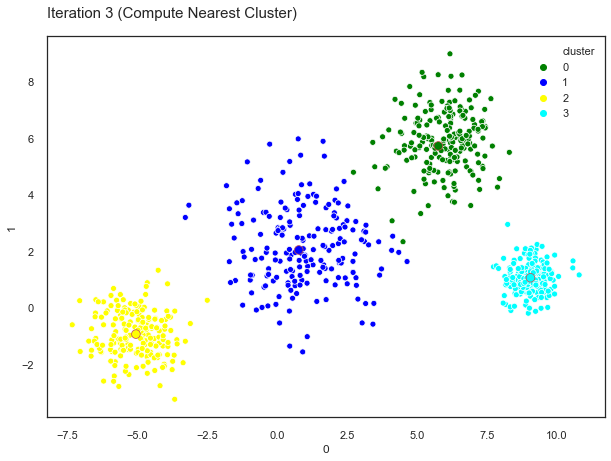

In [103]:
data_df['cluster'] = data_df[[0, 1]].apply(lambda x: find_cluster(x, new_cluster_cntr), axis = 1)
recompute_and_plot(new_cluster_cntr, recompute = False)
plt.annotate('Iteration 3 (Compute Nearest Cluster)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)

cluster
0    0.037774
1    0.061565
2    0.000000
3    0.000000
dtype: float64

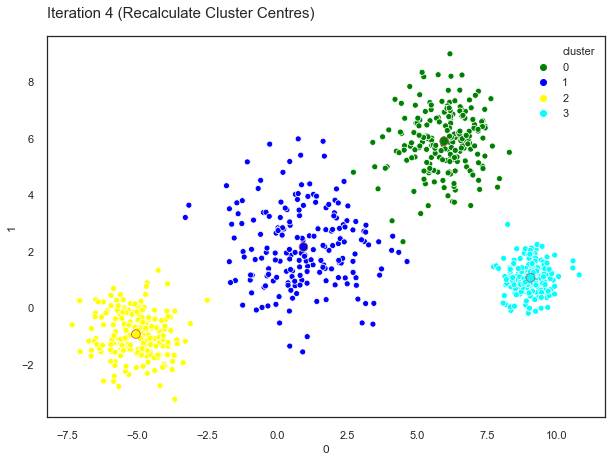

In [104]:
recompute_and_plot(new_cluster_cntr, recompute = True)
plt.annotate('Iteration 4 (Recalculate Cluster Centres)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)
old_cluster_cntr = new_cluster_cntr
new_cluster_cntr = recompute_centroid(data_df)
(old_cluster_cntr - new_cluster_cntr).apply(lambda x: euclidean_distance(x[0], x[1]), axis = 1)

Text(0, 1.05, 'Iteration 4 (Compute Nearest Cluster)')

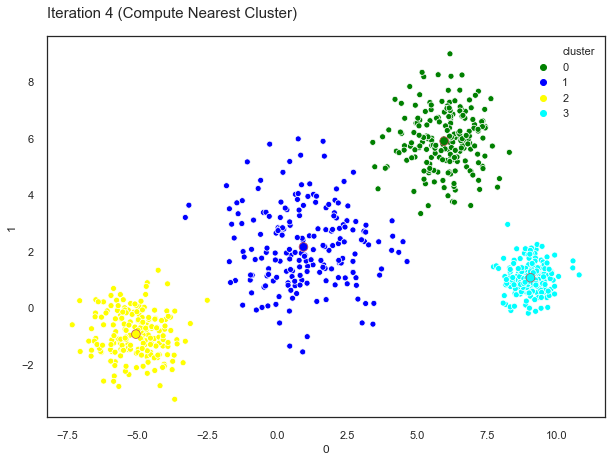

In [105]:
data_df['cluster'] = data_df[[0, 1]].apply(lambda x: find_cluster(x, new_cluster_cntr), axis = 1)
recompute_and_plot(new_cluster_cntr, recompute = False)
plt.annotate('Iteration 4 (Compute Nearest Cluster)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)

cluster
0    0.004548
1    0.024165
2    0.000000
3    0.000000
dtype: float64

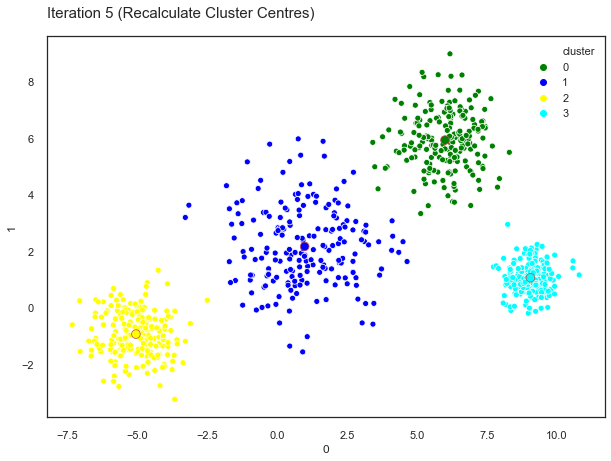

In [106]:
recompute_and_plot(new_cluster_cntr, recompute = True)
plt.annotate('Iteration 5 (Recalculate Cluster Centres)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)
old_cluster_cntr = new_cluster_cntr
new_cluster_cntr = recompute_centroid(data_df)
(old_cluster_cntr - new_cluster_cntr).apply(lambda x: euclidean_distance(x[0], x[1]), axis = 1)

Text(0, 1.05, 'Iteration 5 (Compute Nearest Cluster)')

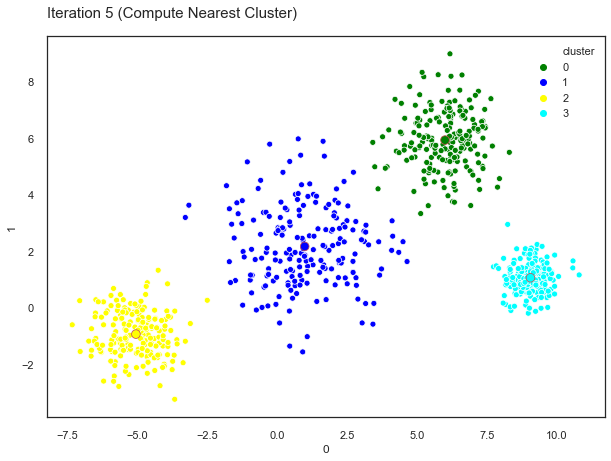

In [107]:
data_df['cluster'] = data_df[[0, 1]].apply(lambda x: find_cluster(x, new_cluster_cntr), axis = 1)
recompute_and_plot(new_cluster_cntr, recompute = False)
plt.annotate('Iteration 5 (Compute Nearest Cluster)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)

cluster
0    0.0
1    0.0
2    0.0
3    0.0
dtype: float64

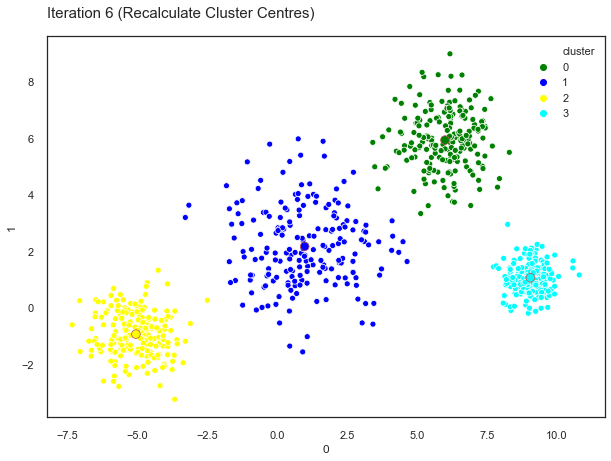

In [108]:
recompute_and_plot(new_cluster_cntr, recompute = True)
plt.annotate('Iteration 6 (Recalculate Cluster Centres)', xy = (0, 1.05), xycoords = 'axes fraction', fontsize = 15)
old_cluster_cntr = new_cluster_cntr
new_cluster_cntr = recompute_centroid(data_df)
(old_cluster_cntr - new_cluster_cntr).apply(lambda x: euclidean_distance(x[0], x[1]), axis = 1)

In [109]:
new_cluster_cntr.reset_index()

cluster         0         1
0        0  6.005330  5.925289
1        1  0.982978  2.157880
2        2 -5.057170 -0.949670
3        3  9.063639  1.046339

Based on the dataset provided, the K-means algorithm found the final cluster centres in 5 iterations. It didn't proceed with iteration 6 since the cluster centres did not change. The final cluster centres are:
1. (6.005330, 5.925289)
2. (0.982978, 2.157880)
3. (-5.057170, -0.949670)
4. (9.063639, 1.046339)